In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================================================
# GPU CONFIGURATION & OPTIMIZATION
# ============================================================================

def setup_gpu():
    """Configure GPU for optimal performance"""
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)
    
    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\n🖥️  Available GPUs: {len(gpus)}")
    
    if gpus:
        try:
            # Enable memory growth (don't allocate all GPU memory at once)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   ✓ GPU: {gpu.name} - Memory growth enabled")
            
            # Set GPU memory limit (optional - useful if sharing GPU)
            # tf.config.set_logical_device_configuration(
            #     gpus[0],
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )
            
            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"   ✓ Mixed precision enabled: {policy.name}")
            
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"   ✓ Logical GPUs: {len(logical_gpus)}")
            
        except RuntimeError as e:
            print(f"   ⚠️  GPU configuration error: {e}")
    else:
        print("   ⚠️  No GPU found - using CPU (training will be slower)")
    
    # Set TensorFlow options for better performance
    tf.config.optimizer.set_jit(True)  # XLA compilation
    print("   ✓ XLA (Accelerated Linear Algebra) enabled")
    
    print(f"\n📊 TensorFlow version: {tf.__version__}")
    print(f"📊 Keras version: {keras.__version__}")
    
    return len(gpus) > 0

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'sequence_length': 10,
    'max_frames_to_predict': 15,
    'batch_size': 256,  # Larger batch for GPU
    'epochs': 100,
    'learning_rate': 0.001,
    'validation_split': 0.15,
    'use_gpu': True,
}

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_euclidean_distance(y_true, y_pred):
    """Calculate Euclidean distance between predicted and actual positions"""
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + 
                       (y_true[:, 1] - y_pred[:, 1])**2)
    return distances

def evaluate_predictions(y_true, y_pred, split_name="Validation"):
    """Comprehensive evaluation of predictions"""
    print("\n" + "="*80)
    print(f"📊 {split_name.upper()} SET EVALUATION")
    print("="*80)
    
    # Overall metrics
    x_rmse = calculate_rmse(y_true[:, 0], y_pred[:, 0])
    y_rmse = calculate_rmse(y_true[:, 1], y_pred[:, 1])
    
    x_mae = calculate_mae(y_true[:, 0], y_pred[:, 0])
    y_mae = calculate_mae(y_true[:, 1], y_pred[:, 1])
    
    # Euclidean distance
    distances = calculate_euclidean_distance(y_true, y_pred)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)
    
    print(f"\n🎯 POSITION ACCURACY:")
    print(f"   X-coordinate:")
    print(f"      RMSE: {x_rmse:.3f} yards")
    print(f"      MAE:  {x_mae:.3f} yards")
    
    print(f"\n   Y-coordinate:")
    print(f"      RMSE: {y_rmse:.3f} yards")
    print(f"      MAE:  {y_mae:.3f} yards")
    
    print(f"\n📏 EUCLIDEAN DISTANCE:")
    print(f"   Mean:   {mean_distance:.3f} yards")
    print(f"   Median: {median_distance:.3f} yards")
    print(f"   Std:    {np.std(distances):.3f} yards")
    print(f"   Min:    {np.min(distances):.3f} yards")
    print(f"   Max:    {np.max(distances):.3f} yards")
    
    # Percentiles
    print(f"\n📊 DISTANCE PERCENTILES:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"   {p}th percentile: {np.percentile(distances, p):.3f} yards")
    
    # Accuracy buckets
    print(f"\n🎯 ACCURACY BUCKETS:")
    for threshold in [1, 2, 5, 10, 15, 20]:
        within = (distances <= threshold).sum()
        pct = 100 * within / len(distances)
        print(f"   Within {threshold:2d} yards: {within:6,} ({pct:5.2f}%)")
    
    metrics = {
        'x_rmse': x_rmse,
        'y_rmse': y_rmse,
        'x_mae': x_mae,
        'y_mae': y_mae,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'distances': distances
    }
    
    return metrics

def plot_predictions(y_true, y_pred, split_name="Validation", save_path="predictions_plot.png"):
    """Visualize predictions vs actual"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. X predictions scatter
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=1)
    ax1.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax1.set_xlabel('Actual X (yards)', fontsize=12)
    ax1.set_ylabel('Predicted X (yards)', fontsize=12)
    ax1.set_title(f'{split_name} - X Coordinate', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # 2. Y predictions scatter
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=1)
    ax2.plot([0, 53.3], [0, 53.3], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Y (yards)', fontsize=12)
    ax2.set_ylabel('Predicted Y (yards)', fontsize=12)
    ax2.set_title(f'{split_name} - Y Coordinate', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # 3. Error distribution
    ax3 = plt.subplot(2, 3, 3)
    distances = calculate_euclidean_distance(y_true, y_pred)
    ax3.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(distances):.2f}')
    ax3.set_xlabel('Euclidean Distance Error (yards)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    x_errors = y_true[:, 0] - y_pred[:, 0]
    ax4.hist(x_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('X Error (yards)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title(f'X Error - Mean: {np.mean(x_errors):.3f}', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    y_errors = y_true[:, 1] - y_pred[:, 1]
    ax5.hist(y_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Y Error (yards)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title(f'Y Error - Mean: {np.mean(y_errors):.3f}', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)
    
    # 6. Cumulative accuracy
    ax6 = plt.subplot(2, 3, 6)
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances) * 100
    ax6.plot(sorted_distances, cumulative, linewidth=2)
    ax6.set_xlabel('Distance Threshold (yards)', fontsize=12)
    ax6.set_ylabel('Cumulative % of Predictions', fontsize=12)
    ax6.set_title('Cumulative Accuracy Curve', fontsize=14, fontweight='bold')
    ax6.grid(alpha=0.3)
    
    # Add benchmarks
    for threshold in [5, 10, 15]:
        pct = (distances <= threshold).sum() / len(distances) * 100
        ax6.axvline(threshold, linestyle='--', alpha=0.5)
        ax6.text(threshold, pct, f'{pct:.1f}%', fontsize=10)
    
    plt.suptitle(f'{split_name} Set - Prediction Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved plot: {save_path}")
    
    return fig

def plot_training_history(history, save_path="training_history.png"):
    """Plot training history"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE (yards)', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved plot: {save_path}")
    
    return fig

# ============================================================================
# IMPORT FUNCTIONS FROM ORIGINAL CODE
# ============================================================================

def parse_height(height_str):
    if pd.isna(height_str):
        return np.nan
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except:
        return np.nan

def calculate_age(birth_date, reference_date='2023-09-01'):
    try:
        birth = pd.to_datetime(birth_date)
        ref = pd.to_datetime(reference_date)
        return (ref - birth).days / 365.25
    except:
        return np.nan

def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)
    
    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")
    
    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")
    
    return train_df

def load_test_data():
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)
    
    test_input = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv')
    test_targets = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv')
    
    print(f"✓ Test input: {len(test_input):,} rows")
    print(f"✓ Test targets: {len(test_targets):,} predictions needed")
    
    return test_input, test_targets

def normalize_play_direction(df):
    df = df.copy()
    left_mask = df['play_direction'] == 'left'
    num_flipped = left_mask.sum()
    
    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
    df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360
    
    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']
    
    print(f"   Normalized {num_flipped:,} plays moving left → right")
    return df

def engineer_features(df):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)
    
    df = df.copy()
    
    print("✓ Computing velocity components (vx, vy)")
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))
    
    print("✓ Computing orientation components (ox, oy)")
    df['ox'] = np.cos(np.radians(df['o']))
    df['oy'] = np.sin(np.radians(df['o']))
    
    if 'ball_land_x' in df.columns:
        print("✓ Computing ball landing features")
        df['dist_to_ball'] = np.sqrt(
            (df['x'] - df['ball_land_x'])**2 + 
            (df['y'] - df['ball_land_y'])**2
        )
        df['angle_to_ball'] = np.arctan2(
            df['ball_land_y'] - df['y'],
            df['ball_land_x'] - df['x']
        )
        df['vel_toward_ball'] = df['s'] * np.cos(np.radians(df['dir']) - df['angle_to_ball'])
    else:
        df['dist_to_ball'] = 0
        df['angle_to_ball'] = 0
        df['vel_toward_ball'] = 0
    
    print("✓ Computing field position features")
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
    df['dist_to_endzone'] = 120 - df['x']
    
    print("✓ Processing player attributes")
    df['height_inches'] = df['player_height'].apply(parse_height)
    df['height_inches'] = df['height_inches'].fillna(df['height_inches'].median())
    
    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['player_age'] = df['player_age'].fillna(df['player_age'].median())
    
    df['bmi'] = (df['player_weight'] * 703) / (df['height_inches'] ** 2)
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
    
    print("✓ Creating temporal features (lags, differences)")
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    
    group_cols = ['game_id', 'play_id', 'nfl_id']
    for lag in [1, 2, 3]:
        for col in ['x', 'y', 's', 'a', 'vx', 'vy']:
            df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)
    
    df['speed_change'] = df.groupby(group_cols)['s'].diff()
    df['accel_change'] = df.groupby(group_cols)['a'].diff()
    df['dir_change'] = df.groupby(group_cols)['dir'].diff()
    
    df.loc[df['dir_change'] > 180, 'dir_change'] -= 360
    df.loc[df['dir_change'] < -180, 'dir_change'] += 360
    
    print("✓ Computing rolling statistics")
    for col in ['s', 'a']:
        df[f'{col}_roll_mean'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df[f'{col}_roll_std'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).std()
        )
    
    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    print(f"\n📊 Features created: {len(df.columns)} total columns")
    
    return df

def encode_categorical(df, encoders=None):
    df = df.copy()
    categorical_cols = ['player_position', 'player_side', 'player_role']
    
    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        return df, encoders
    else:
        for col in categorical_cols:
            if col in encoders:
                df[col] = df[col].astype(str).map(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df[col] = encoders[col].transform(df[col])
        return df

def create_sequences(df, sequence_length=10, for_training=True):
    print("\n" + "="*80)
    print("CREATING SEQUENCES")
    print("="*80)
    
    sequence_features = [
        'x', 'y', 's', 'a', 'vx', 'vy', 'ox', 'oy', 'dir', 'o',
        'x_lag1', 'y_lag1', 's_lag1', 'a_lag1',
        'x_lag2', 'y_lag2', 's_lag2', 'a_lag2',
        'x_lag3', 'y_lag3', 's_lag3', 'a_lag3',
        'speed_change', 'accel_change', 'dir_change',
        's_roll_mean', 'a_roll_mean',
        'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline'
    ]
    
    static_features = [
        'player_position', 'player_side', 'player_role',
        'height_inches', 'player_weight', 'player_age', 'bmi',
        'absolute_yardline_number', 'dist_to_ball', 'angle_to_ball'
    ]
    
    sequences = []
    static_data = []
    targets = []
    metadata = []
    
    grouped = df.groupby(['game_id', 'play_id', 'nfl_id'])
    
    for (game_id, play_id, nfl_id), group in grouped:
        if for_training and not group['player_to_predict'].any():
            continue
        
        group = group.sort_values('frame_id')
        
        if len(group) < sequence_length:
            continue
        
        seq_data = group[sequence_features].iloc[-sequence_length:].values
        static = group[static_features].iloc[-1].values
        
        sequences.append(seq_data)
        static_data.append(static)
        
        if for_training and 'ball_land_x' in group.columns:
            target_x = group['ball_land_x'].iloc[-1]
            target_y = group['ball_land_y'].iloc[-1]
            targets.append([target_x, target_y])
        
        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': nfl_id,
            'num_frames_output': group['num_frames_output'].iloc[-1] if 'num_frames_output' in group.columns else 0,
            'last_x': group['x'].iloc[-1],
            'last_y': group['y'].iloc[-1],
        })
    
    sequences = np.array(sequences, dtype=np.float32)
    static_data = np.array(static_data, dtype=np.float32)
    
    if for_training and len(targets) > 0:
        targets = np.array(targets, dtype=np.float32)
    else:
        targets = None
    
    print(f"✓ Created {len(sequences):,} sequences")
    print(f"✓ Sequence shape: {sequences.shape}")
    print(f"✓ Static shape: {static_data.shape}")
    if targets is not None:
        print(f"✓ Target shape: {targets.shape}")
    
    return sequences, static_data, targets, metadata

def build_model(sequence_shape, static_shape):
    print("\n" + "="*80)
    print("BUILDING MODEL")
    print("="*80)
    
    sequence_input = layers.Input(shape=sequence_shape, name='sequence_input')
    
    x = layers.LSTM(128, return_sequences=True)(sequence_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    static_input = layers.Input(shape=(static_shape,), name='static_input')
    s = layers.Dense(64, activation='relu')(static_input)
    s = layers.BatchNormalization()(s)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation='relu')(s)
    
    combined = layers.concatenate([x, s])
    
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)
    
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)
    
    # For mixed precision, use float32 output
    output = layers.Dense(2, dtype='float32', name='position_output')(z)
    
    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    model.summary()
    
    return model

def train_model(model, X_seq, X_static, y, validation_split=0.15):
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        [X_seq, X_static], y,
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

def create_submission(model, test_input, test_targets, metadata_lookup, scalers):
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS")
    print("="*80)
    
    pred_dict = {}
    for meta, pred in zip(metadata_lookup, model.predict([test_input[0], test_input[1]], verbose=1)):
        key = (meta['game_id'], meta['play_id'], meta['nfl_id'])
        pred_dict[key] = {
            'x': pred[0],
            'y': pred[1],
            'last_x': meta['last_x'],
            'last_y': meta['last_y']
        }
    
    submissions = []
    for _, row in test_targets.iterrows():
        key = (row['game_id'], row['play_id'], row['nfl_id'])
        
        if key in pred_dict:
            x_pred = pred_dict[key]['x']
            y_pred = pred_dict[key]['y']
        else:
            x_pred = 60.0
            y_pred = 26.65
        
        submissions.append({
            'id': f"{row['game_id']}_{row['play_id']}_{row['nfl_id']}_{row['frame_id']}",
            'x': x_pred,
            'y': y_pred
        })
    
    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv('submission.csv', index=False)
    
    print(f"✓ Submission created: {len(submission_df):,} predictions")
    print(f"✓ Saved to: submission.csv")
    
    return submission_df

# ============================================================================
# MAIN PIPELINE WITH EVALUATION
# ============================================================================
'''
def main():
    start_time = datetime.now()
    
    print("\n" + "="*80)
    print(" NFL BIG DATA BOWL 2026 - ENHANCED PIPELINE WITH EVALUATION")
    print("="*80)
    
    # Setup GPU
    has_gpu = setup_gpu()
    
    # Load data
    train_df = load_training_data()
    test_input_df, test_targets_df = load_test_data()
    
    # Preprocess
    print("\n📍 Step 1: Normalizing play direction...")
    train_df = normalize_play_direction(train_df)
    test_input_df = normalize_play_direction(test_input_df)
    
    # Feature engineering
    print("\n📍 Step 2: Feature engineering...")
    train_df = engineer_features(train_df)
    test_input_df = engineer_features(test_input_df)
    
    # Encode categorical
    print("\n📍 Step 3: Encoding categorical variables...")
    train_df, encoders = encode_categorical(train_df)
    test_input_df = encode_categorical(test_input_df, encoders)
    
    # Create sequences
    print("\n📍 Step 4: Creating sequences...")
    X_seq_all, X_static_all, y_all, metadata_all = create_sequences(
        train_df, CONFIG['sequence_length'], for_training=True
    )
    
    X_seq_test, X_static_test, _, metadata_test = create_sequences(
        test_input_df, CONFIG['sequence_length'], for_training=False
    )
    
    # Split train/validation
    print("\n📍 Step 5: Splitting train/validation...")
    n_samples = len(X_seq_all)
    n_val = int(n_samples * CONFIG['validation_split'])
    
    # Random shuffle
    indices = np.random.permutation(n_samples)
    train_idx = indices[n_val:]
    val_idx = indices[:n_val]
    
    X_seq_train = X_seq_all[train_idx]
    X_static_train = X_static_all[train_idx]
    y_train = y_all[train_idx]
    
    X_seq_val = X_seq_all[val_idx]
    X_static_val = X_static_all[val_idx]
    y_val = y_all[val_idx]
    
    print(f"   Training samples: {len(X_seq_train):,}")
    print(f"   Validation samples: {len(X_seq_val):,}")
    
    # Scale features
    print("\n📍 Step 6: Scaling features...")
    scaler_seq = StandardScaler()
    scaler_static = StandardScaler()
    
    # Scale sequence features
    X_seq_train_flat = X_seq_train.reshape(-1, X_seq_train.shape[-1])
    X_seq_train_scaled = scaler_seq.fit_transform(X_seq_train_flat).reshape(X_seq_train.shape)
    
    X_seq_val_flat = X_seq_val.reshape(-1, X_seq_val.shape[-1])
    X_seq_val_scaled = scaler_seq.transform(X_seq_val_flat).reshape(X_seq_val.shape)
    
    # Scale static features
    X_static_train_scaled = scaler_static.fit_transform(X_static_train)
    X_static_val_scaled = scaler_static.transform(X_static_val)
    
    # Scale test features
    X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
    X_seq_test_scaled = scaler_seq.transform(X_seq_test_flat).reshape(X_seq_test.shape)
    X_static_test_scaled = scaler_static.transform(X_static_test)
    
    # Build model
    print("\n📍 Step 7: Building model...")
    model = build_model(
        sequence_shape=(X_seq_train.shape[1], X_seq_train.shape[2]),
        static_shape=X_static_train.shape[1]
    )
    
    # Train model WITHOUT validation_split (we already split)
    print("\n📍 Step 8: Training model...")
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        [X_seq_train_scaled, X_static_train_scaled], y_train,
        validation_data=([X_seq_val_scaled, X_static_val_scaled], y_val),
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    print("\n📍 Step 9: Plotting training history...")
    plot_training_history(history, "training_history.png")
    
    # Evaluate on training set
    print("\n📍 Step 10: Evaluating on training set...")
    y_train_pred = model.predict([X_seq_train_scaled, X_static_train_scaled], verbose=0)
    train_metrics = evaluate_predictions(y_train, y_train_pred, "Training")
    plot_predictions(y_train, y_train_pred, "Training", "predictions_train.png")
    
    # Evaluate on validation set
    print("\n📍 Step 11: Evaluating on validation set...")
    y_val_pred = model.predict([X_seq_val_scaled, X_static_val_scaled], verbose=0)
    val_metrics = evaluate_predictions(y_val, y_val_pred, "Validation")
    plot_predictions(y_val, y_val_pred, "Validation", "predictions_val.png")
    
    # Save model and artifacts
    print("\n📍 Step 12: Saving model and artifacts...")
    model.save('nfl_model_final.keras')
    with open('scalers.pkl', 'wb') as f:
        pickle.dump({'seq': scaler_seq, 'static': scaler_static, 'encoders': encoders}, f)
    
    # Save metrics to file
    metrics_summary = {
        'training': {
            'x_rmse': float(train_metrics['x_rmse']),
            'y_rmse': float(train_metrics['y_rmse']),
            'x_mae': float(train_metrics['x_mae']),
            'y_mae': float(train_metrics['y_mae']),
            'mean_distance': float(train_metrics['mean_distance']),
            'median_distance': float(train_metrics['median_distance'])
        },
        'validation': {
            'x_rmse': float(val_metrics['x_rmse']),
            'y_rmse': float(val_metrics['y_rmse']),
            'x_mae': float(val_metrics['x_mae']),
            'y_mae': float(val_metrics['y_mae']),
            'mean_distance': float(val_metrics['mean_distance']),
            'median_distance': float(val_metrics['median_distance'])
        }
    }
    
    with open('metrics.pkl', 'wb') as f:
        pickle.dump(metrics_summary, f)
    
    # Create submission
    print("\n📍 Step 13: Creating submission...")
    submission = create_submission(
        model, 
        (X_seq_test_scaled, X_static_test_scaled),
        test_targets_df,
        metadata_test,
        {'seq': scaler_seq, 'static': scaler_static}
    )
    
    # Final summary
    end_time = datetime.now()
    duration = end_time - start_time
    
    print("\n" + "="*80)
    print("✅ PIPELINE COMPLETE!")
    print("="*80)
    
    print(f"\n⏱️  Total Time: {duration}")
    
    print(f"\n📁 Files created:")
    print(f"   • nfl_model_final.keras - Trained model")
    print(f"   • best_model.keras - Best model checkpoint")
    print(f"   • scalers.pkl - Feature scalers and encoders")
    print(f"   • metrics.pkl - Evaluation metrics")
    print(f"   • submission.csv - Final predictions ({len(submission):,} rows)")
    print(f"   • training_history.png - Training curves")
    print(f"   • predictions_train.png - Training set predictions")
    print(f"   • predictions_val.png - Validation set predictions")
    
    print(f"\n📊 FINAL RESULTS:")
    print(f"\n   Training Set:")
    print(f"      RMSE (X): {train_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {train_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {train_metrics['mean_distance']:.3f} yards")
    
    print(f"\n   Validation Set:")
    print(f"      RMSE (X): {val_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {val_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {val_metrics['mean_distance']:.3f} yards")
    
    print(f"\n🎯 Model Performance Summary:")
    within_5_val = (val_metrics['distances'] <= 5).sum() / len(val_metrics['distances']) * 100
    within_10_val = (val_metrics['distances'] <= 10).sum() / len(val_metrics['distances']) * 100
    print(f"   Predictions within 5 yards: {within_5_val:.1f}%")
    print(f"   Predictions within 10 yards: {within_10_val:.1f}%")
    
    print("\n" + "="*80)
    
    return model, history, submission, train_metrics, val_metrics

# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    model, history, submission, train_metrics, val_metrics = main()

'''

2025-10-15 04:34:46.172284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760502886.352638      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760502886.411411      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'\ndef main():\n    start_time = datetime.now()\n    \n    print("\n" + "="*80)\n    print(" NFL BIG DATA BOWL 2026 - ENHANCED PIPELINE WITH EVALUATION")\n    print("="*80)\n    \n    # Setup GPU\n    has_gpu = setup_gpu()\n    \n    # Load data\n    train_df = load_training_data()\n    test_input_df, test_targets_df = load_test_data()\n    \n    # Preprocess\n    print("\n📍 Step 1: Normalizing play direction...")\n    train_df = normalize_play_direction(train_df)\n    test_input_df = normalize_play_direction(test_input_df)\n    \n    # Feature engineering\n    print("\n📍 Step 2: Feature engineering...")\n    train_df = engineer_features(train_df)\n    test_input_df = engineer_features(test_input_df)\n    \n    # Encode categorical\n    print("\n📍 Step 3: Encoding categorical variables...")\n    train_df, encoders = encode_categorical(train_df)\n    test_input_df = encode_categorical(test_input_df, encoders)\n    \n    # Create sequences\n    print("\n📍 Step 4: Creating sequences...")\

In [3]:
DF_NBL_PURE = load_training_data()

NameError: name 'load_training_data' is not defined

In [4]:
from sklearn.preprocessing import LabelEncoder
!pip install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com -q
!nvidia-smi


# ============================================================================
# Cargar datos
# ============================================================================
    
print(".head")
print("###########################################################")
print(DF_NBL_PURE.head()) #informacion de cabecera-> util para ver ejemplo de 5 muestras
print(".info")
print("###########################################################")
print(DF_NBL_PURE.info()) #informacion general de data frame(muestra caracteristicas y tipo de dato) -> informacion de caracteristicas
print(".count")
print("###########################################################")
print(DF_NBL_PURE.count())#informacion de reconteo de datos por caracteristicas -> util para verificar datos perdidos tanto para hacer inputacion o o eliminacion de datos
print(".describe")
print("###########################################################")
print(DF_NBL_PURE.describe())


    


Wed Oct 15 04:35:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Informacion Obtenida y exploracion

La base de datos contiene informacion de partidos del 2024 donde nos indican diferentes varibles de cada juego, el objetivo principal es predecir la posición del jugador en el campo (targets: x_aligned y y_aligned si existen; de lo contrario x y y). El tracking está a 10 Hz (≈ 10 fotogramas por segundo).
Informacion de cabecera metodo .head() -> Vimos ejemplo de informacion, util para ver de como se componen en forma de tabla

Informacion de caracteristicas metodo .info() -> podemos ver el tipo de datos por caracterisitca, definimos que puede ser importante para el modelo:

- Identificaciones: claves para uniones y para agrupar secuencias por jugador-jugada.
- game_id -> identificador único de cada partido
- play_id   -> identificador de jugada por cada partido
- nfl_id      -> id unico del jugador 
- frame_id-> Numero del fotograma de cada jugada, se registra con frecuencia de 10 Hz

Variables de posición 
- X - > posición de jugador en eje horizontal en yardas de 0 a 120
- Y - > posición de jugador en eje vertical en yardas de 0 a 53.3
- s -> Velocidad en yardas/segundos del jugador 
- a-> Aceleración en yardas/segundos^2 del jugador 
- dir-> dirección de moviento en grados (hacia donde se esta moviendo)
- o -> orientación (Hacia donde mira el jugador en grados)
- play_direction -> indica si la ofensiva ataca a la izquierda (left) o derecha (right)

- información/características de jugador:
- player_name -> Nombre del jugador
- player_height-> Altura del jugador
- player_weight-> Peso del jugador
- player_birth_date -> Edad 
- Player_posiition -> Rol típico (WR, CB, QB, etc.)
- player_side -> Ofensiva o defensiva.
- player_role -> Rol específico en esa jugada (pasador, receptor, cobertura, etc.)

Tratamiento de datos propuesta:

- Eliminacion de game_id, play_id: Estos datos pueden Generar que el modelo solo memorice o asimile por el identificador mas no generalice independientemente.
- Encoding de play_direction: 1 para derecha, -1 izquierda.
- Eliminacion de player_name: redundante ya que existe el id del jugador
- Transformaciones a pulgadas de player_height
- Transformacion a edad de player_birth_date
- Transformacion hot encoder de player_position
- Transformacion binaria player_side: 0 defensa 1 Ataque
- Transformacion label encodding de player_role
- Transformacion dir a dir_x = cos(dir) y dir_y = sin(dir) para evitar discontinuidad angular al igual 'o'


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# ==============================
# === Limpieza y preparación ===
# ==============================

data = DF_NBL_PURE.copy()

# === 1. Eliminar columnas innecesarias ===
data.drop(columns=['game_id', 'play_id', 'player_name'], inplace=True, errors='ignore')

# === 2. Codificar play_direction (right=1, left=-1) ===
data['play_direction'] = np.where(
    data['play_direction'].astype(str).str.lower().str.strip() == 'right', 1,
    np.where(data['play_direction'].astype(str).str.lower().str.strip() == 'left', -1, np.nan)
)

# ==============================
# === NUEVO: Alinear campo ===
# ==============================
FIELD_LENGTH = 120.0
FIELD_WIDTH = 53.3

# Refleja jugadas hacia la izquierda para que todas apunten hacia la derecha
data['x_aligned'] = np.where(data['play_direction'] == -1, FIELD_LENGTH - data['x'], data['x'])
data['y_aligned'] = np.where(data['play_direction'] == -1, FIELD_WIDTH - data['y'], data['y'])

# Nota: A partir de aquí, usa x_aligned y y_aligned en lugar de x e y
# Si prefieres, puedes reemplazarlos:
# data['x'], data['y'] = data['x_aligned'], data['y_aligned']
# data.drop(columns=['x_aligned', 'y_aligned'], inplace=True)

# === 3. Normalizar player_height a pulgadas (vectorizado) ===
mask = data['player_height'].astype(str).str.contains('-', na=False)
split_heights = data.loc[mask, 'player_height'].str.extract(r'(\d+)-(\d+)').astype(float)
data.loc[mask, 'player_height'] = split_heights[0] * 12 + split_heights[1]
data['player_height'] = pd.to_numeric(data['player_height'], errors='coerce')

# === 4. Calcular edad del jugador (años) ===
data['player_birth_date'] = pd.to_datetime(data['player_birth_date'], errors='coerce')
today = pd.Timestamp(datetime.today())
data['player_age'] = (today - data['player_birth_date']).dt.days.div(365.25)
data.drop(columns=['player_birth_date'], inplace=True)

# === 5. Codificar player_side ===
if 'player_side' in data.columns:
    data['player_side'] = (
        data['player_side']
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({
            'defense': 'defense',
            'def': 'defense',
            'offense': 'offense',
            'off': 'offense',
            '0': 'defense',
            '1': 'offense'
        })
        .map({'defense': 0, 'offense': 1})
    )

# === 6. Simplificar posiciones poco comunes ===
position_counts = data['player_position'].value_counts()
rare_positions = position_counts.index[position_counts < 1000]
data['player_position'] = data['player_position'].where(~data['player_position'].isin(rare_positions), 'OTHER')

# One-Hot Encoding
data = pd.get_dummies(data, columns=['player_position'], prefix='pos', dtype=int)

# === 7. Codificar player_role ===
if data['player_role'].nunique() <= 10:
    data = pd.get_dummies(data, columns=['player_role'], prefix='role', dtype=int)
else:
    le = LabelEncoder()
    data['player_role'] = le.fit_transform(data['player_role'].astype(str))

# === 8. Direcciones 'dir' y 'o' como vectores unitarios ===
for col in ['dir', 'o']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

rads = np.deg2rad(data[['dir', 'o']])
data['dir_x'], data['dir_y'] = np.cos(rads['dir']), np.sin(rads['dir'])
data['o_x'], data['o_y'] = np.cos(rads['o']), np.sin(rads['o'])
data.drop(columns=['dir', 'o'], inplace=True)

# === 9. Limpieza de NaN e infinitos ===
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['s', 'a', 'x', 'y'], inplace=True)
data.fillna(data.mean(numeric_only=True), inplace=True)

# === 10. Normalización (vectorizada) ===
for col in ['s', 'a']:
    mean, std = data[col].mean(), data[col].std()
    data[col] = (data[col] - mean) / std

# === 11. Información final ===
data.info()
print("\n✅ Campo alineado: todas las jugadas apuntan hacia la derecha (x,y ajustados).")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 42 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   player_to_predict         bool   
 1   nfl_id                    int64  
 2   frame_id                  int64  
 3   play_direction            float64
 4   absolute_yardline_number  int64  
 5   player_height             float64
 6   player_weight             int64  
 7   player_side               int64  
 8   x                         float64
 9   y                         float64
 10  s                         float64
 11  a                         float64
 12  num_frames_output         int64  
 13  ball_land_x               float64
 14  ball_land_y               float64
 15  x_aligned                 float64
 16  y_aligned                 float64
 17  player_age                float64
 18  pos_CB                    int64  
 19  pos_DE                    int64  
 20  pos_DT                  

In [2]:
# 2. Calcular la matriz de correlación
correlation_matrix = data.corr()

# 3. Configurar el tamaño del gráfico
plt.figure(figsize=(10, 10))

# 4. Crear el mapa de calor con anotaciones y paleta de colores
sns.heatmap(
    correlation_matrix,
    annot=True,        # Mostrar el valor numérico de la correlación en cada celda
    cmap='coolwarm',   # Paleta de colores. 'coolwarm' es ideal para correlación (rojo/azul)
    fmt=".2f",         # Formato para los números (2 decimales)
    linewidths=.5,     # Líneas divisorias
    cbar=True          # Mostrar la barra de color lateral
)

# 5. Añadir título y mostrar el gráfico
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

NameError: name 'data' is not defined

array([[<Axes: title={'center': 'nfl_id'}>,
        <Axes: title={'center': 'frame_id'}>,
        <Axes: title={'center': 'play_direction'}>,
        <Axes: title={'center': 'absolute_yardline_number'}>,
        <Axes: title={'center': 'player_height'}>,
        <Axes: title={'center': 'player_weight'}>],
       [<Axes: title={'center': 'player_side'}>,
        <Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>,
        <Axes: title={'center': 's'}>, <Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'num_frames_output'}>],
       [<Axes: title={'center': 'ball_land_x'}>,
        <Axes: title={'center': 'ball_land_y'}>,
        <Axes: title={'center': 'x_aligned'}>,
        <Axes: title={'center': 'y_aligned'}>,
        <Axes: title={'center': 'player_age'}>,
        <Axes: title={'center': 'pos_CB'}>],
       [<Axes: title={'center': 'pos_DE'}>,
        <Axes: title={'center': 'pos_DT'}>,
        <Axes: title={'center': 'pos_FB'}>,
        <Axes: title={'center':

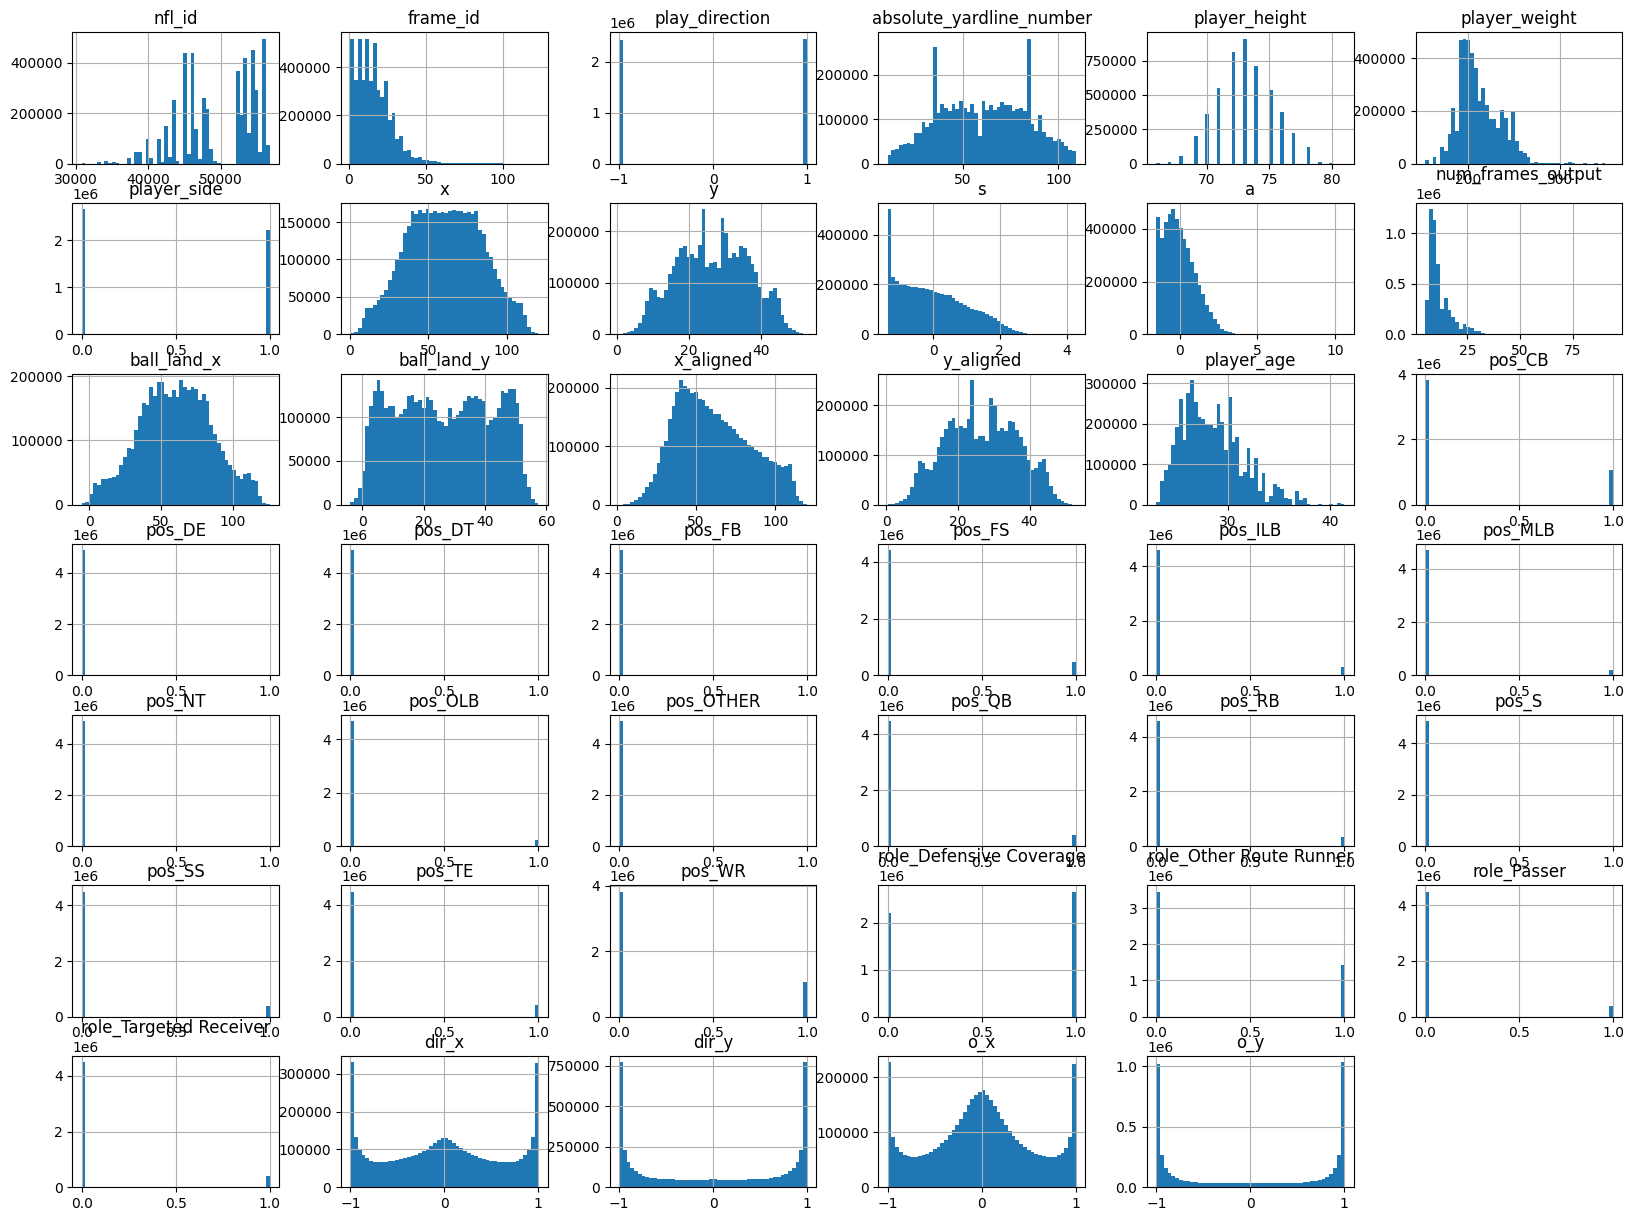

In [7]:
data.hist(bins=50, figsize=(20,15))

In [8]:
print(data.count())

player_to_predict           4880579
nfl_id                      4880579
frame_id                    4880579
play_direction              4880579
absolute_yardline_number    4880579
player_height               4880579
player_weight               4880579
player_side                 4880579
x                           4880579
y                           4880579
s                           4880579
a                           4880579
num_frames_output           4880579
ball_land_x                 4880579
ball_land_y                 4880579
x_aligned                   4880579
y_aligned                   4880579
player_age                  4880579
pos_CB                      4880579
pos_DE                      4880579
pos_DT                      4880579
pos_FB                      4880579
pos_FS                      4880579
pos_ILB                     4880579
pos_MLB                     4880579
pos_NT                      4880579
pos_OLB                     4880579
pos_OTHER                   

In [9]:
# =========================================================
# 🚀 MULTI-OUTPUT LINEAR REGRESSION (RAPIDS) CON LIMPIEZA
# =========================================================


import cudf, cuml
import cupy as cp
from cuml.model_selection import train_test_split
from cuml.linear_model import LinearRegression
from cuml.metrics import r2_score, mean_squared_error

# =========================================================
# 1️⃣ Convertir DataFrame de pandas a cuDF
# =========================================================
gdf = cudf.DataFrame.from_pandas(data)

# =========================================================
# 2️⃣ Eliminar o imputar valores nulos
# =========================================================
# Opción 1: eliminar filas con nulos (seguro pero puede reducir datos)
gdf = gdf.dropna()

# Opción 2 (alternativa): imputar media para no perder datos
# gdf = gdf.fillna(gdf.mean())

# =========================================================
# 3️⃣ Separar variables de entrada (X) y salida (y)
# =========================================================
y = gdf[['x', 'y']]          # Salidas
X = gdf.drop(columns=['x', 'y'])  # Entradas

# =========================================================
# 4️⃣ Partición 60/20/20
# =========================================================
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Tamaños de los conjuntos:")
print(f"Entrenamiento: {len(X_train)}  |  Validación: {len(X_valid)}  |  Test: {len(X_test)}")

# =========================================================
# 5️⃣ Entrenamiento (dos modelos, uno para cada coordenada)
# =========================================================
model_x = LinearRegression()
model_y = LinearRegression()

model_x.fit(X_train, y_train['x'])
model_y.fit(X_train, y_train['y'])

# =========================================================
# 6️⃣ Predicciones
# =========================================================
y_pred_valid_x = model_x.predict(X_valid)
y_pred_valid_y = model_y.predict(X_valid)
y_pred_test_x  = model_x.predict(X_test)
y_pred_test_y  = model_y.predict(X_test)

# =========================================================
# 7️⃣ Evaluación
# =========================================================
r2_valid_x = r2_score(y_valid['x'], y_pred_valid_x)
r2_valid_y = r2_score(y_valid['y'], y_pred_valid_y)
mse_valid_x = mean_squared_error(y_valid['x'], y_pred_valid_x)
mse_valid_y = mean_squared_error(y_valid['y'], y_pred_valid_y)

r2_test_x = r2_score(y_test['x'], y_pred_test_x)
r2_test_y = r2_score(y_test['y'], y_pred_test_y)
mse_test_x = mean_squared_error(y_test['x'], y_pred_test_x)
mse_test_y = mean_squared_error(y_test['y'], y_pred_test_y)

print("\n📊 Resultados VALIDACIÓN:")
print(f"R² (x): {r2_valid_x:.4f} | MSE (x): {mse_valid_x:.4f}")
print(f"R² (y): {r2_valid_y:.4f} | MSE (y): {mse_valid_y:.4f}")

print("\n📊 Resultados TEST:")
print(f"R² (x): {r2_test_x:.4f} | MSE (x): {mse_test_x:.4f}")
print(f"R² (y): {r2_test_y:.4f} | MSE (y): {mse_test_y:.4f}")


Tamaños de los conjuntos:
Entrenamiento: 2928348  |  Validación: 976116  |  Test: 976115

📊 Resultados VALIDACIÓN:
R² (x): 0.9456 | MSE (x): 30.0597
R² (y): 0.1505 | MSE (y): 84.9671

📊 Resultados TEST:
R² (x): 0.9454 | MSE (x): 30.1192
R² (y): 0.1527 | MSE (y): 84.9351


In [10]:
# =========================================================
# ⚡ LASSO (x,y) con RAPIDS — v3 (CV + interacciones + GPU metrics)
#  - CV K=3 en submuestra para alpha
#  - Features físicas + interacciones baratas
#  - Métricas en GPU (sin copias innecesarias)
# =========================================================

import numpy as np, pandas as pd, cudf, cupy as cp
from cudf import concat as cudf_concat
from cuml.preprocessing import StandardScaler
from cuml.linear_model import Lasso
from cuml.metrics import mean_squared_error as gpu_mse

# ----------------------------
# 0) Parámetros
# ----------------------------
RANDOM_STATE = 42
SUBSAMPLE_TUNE_MAX  = 200_000   # filas máx para CV (rápido)
KFOLDS = 3                      # CV sencillo
ALPHAS = np.logspace(-6, -1, 12)  # más ancho y denso [1e-6 … 1e-1]
MAX_ITER = 3000
TOL = 1e-4

rng = np.random.RandomState(RANDOM_STATE)

# ----------------------------
# 1) Datos de entrada (pandas) y targets
# ----------------------------
df = data.copy()
targets = ['x_aligned','y_aligned'] if {'x_aligned','y_aligned'}.issubset(df.columns) else ['x','y']
df = df.dropna(subset=targets).reset_index(drop=True)

# ----------------------------
# 1.1 Features físicas + interacciones (baratas y opcionales)
# ----------------------------
def add_physics_features(df):
    # básicos
    if {'s','dir_x','dir_y'}.issubset(df.columns):
        df['vx'] = df['s'] * df['dir_x']
        df['vy'] = df['s'] * df['dir_y']
    if {'a','dir_x','dir_y'}.issubset(df.columns):
        df['ax_c'] = df['a'] * df['dir_x']
        df['ay_c'] = df['a'] * df['dir_y']
    if 's' in df.columns: df['s_sq'] = df['s']**2
    if 'a' in df.columns: df['a_sq'] = df['a']**2
    if 'absolute_yardline_number' in df.columns:
        df['dist_to_end'] = 120.0 - df['absolute_yardline_number']
    # interacciones baratas (si existen)
    for p in [('vx','ax_c'), ('vy','ay_c'), ('s','a')]:
        if all(col in df.columns for col in p):
            df[f'{p[0]}_x_{p[1]}'] = df[p[0]] * df[p[1]]
    return df

df = add_physics_features(df)

# ----------------------------
# 2) Split 60/20/20 aleatorio (determinista)
# ----------------------------
idx = np.arange(len(df)); rng.shuffle(idx)
n = len(df); n_tr = int(0.6*n); n_va = int(0.2*n)
tr_idx = idx[:n_tr]; va_idx = idx[n_tr:n_tr+n_va]; te_idx = idx[n_tr+n_va:]

# ----------------------------
# 3) X / y (excluir columnas que no deben entrar)
# ----------------------------
drop_cols = [c for c in (set(targets) | {'x','y','x_aligned','y_aligned',
                                         'ball_land_x','ball_land_y','num_frames_output',
                                         'player_to_predict','nfl_id','frame_id','player_name'}) if c in df.columns]
X_pd = df.drop(columns=drop_cols, errors='ignore').copy()
y_pd = df[targets].astype('float32').copy()

# asegurar numérico en X (simple y robusto)
for c in X_pd.select_dtypes(include='bool').columns:
    X_pd[c] = X_pd[c].astype(np.int8)
for c in X_pd.columns:
    if X_pd[c].dtype == 'O':
        X_pd[c] = pd.to_numeric(X_pd[c], errors='coerce')
X_pd = X_pd.fillna(X_pd.mean(numeric_only=True)).astype('float32')

# eliminar columnas de varianza ~0 (no aportan y pueden estorbar a L1)
num_var = X_pd.var(numeric_only=True)
const_cols = list(num_var[(num_var <= 0)].index)
if const_cols:
    X_pd.drop(columns=const_cols, inplace=True)

# ----------------------------
# 4) A cuDF (GPU) + escalado
# ----------------------------
gX = cudf.from_pandas(X_pd)
gy = cudf.from_pandas(y_pd)

X_tr, X_va, X_te = gX.iloc[tr_idx], gX.iloc[va_idx], gX.iloc[te_idx]
y_tr, y_va, y_te = gy.iloc[tr_idx], gy.iloc[va_idx], gy.iloc[te_idx]

print(f"Split -> Train: {len(X_tr):,} | Valid: {len(X_va):,} | Test: {len(X_te):,}")

scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(X_tr)
Xva_s = scaler.transform(X_va)
Xte_s = scaler.transform(X_te)

# ----------------------------
# 5) Submuestreo + K-Fold CV para alpha
# ----------------------------
def pick_subsample(n_rows, cap, seed=RANDOM_STATE):
    if n_rows <= cap: 
        return np.arange(n_rows)
    rng_local = np.random.RandomState(seed)
    return np.sort(rng_local.choice(n_rows, size=cap, replace=False))

sub = pick_subsample(len(Xtr_s), SUBSAMPLE_TUNE_MAX, RANDOM_STATE)
Xsub = Xtr_s.iloc[sub]
y_x_sub = y_tr[targets[0]].iloc[sub]
y_y_sub = y_tr[targets[1]].iloc[sub]

def kfold_indices(n, k=3, seed=RANDOM_STATE):
    rng_local = np.random.RandomState(seed)
    perm = rng_local.permutation(n)
    folds = np.array_split(perm, k)
    return folds

folds = kfold_indices(len(Xsub), KFOLDS, RANDOM_STATE)

def cv_mse_macro(alpha):
    mse_sum = 0.0
    for f in range(KFOLDS):
        val_idx = folds[f]
        train_idx = np.concatenate([folds[j] for j in range(KFOLDS) if j != f])

        X_tr_cv = Xsub.iloc[train_idx]; X_va_cv = Xsub.iloc[val_idx]
        yx_tr = y_x_sub.iloc[train_idx]; yx_va = y_x_sub.iloc[val_idx]
        yy_tr = y_y_sub.iloc[train_idx]; yy_va = y_y_sub.iloc[val_idx]

        mx = Lasso(alpha=float(alpha), max_iter=MAX_ITER, tol=TOL, fit_intercept=True)
        my = Lasso(alpha=float(alpha), max_iter=MAX_ITER, tol=TOL, fit_intercept=True)
        mx.fit(X_tr_cv, yx_tr); my.fit(X_tr_cv, yy_tr)

        px = mx.predict(X_va_cv)
        py = my.predict(X_va_cv)

        mse_x = gpu_mse(yx_va, px)
        mse_y = gpu_mse(yy_va, py)
        mse_sum += 0.5 * (float(mse_x) + float(mse_y))
    return mse_sum / KFOLDS

best_alpha, best_score = None, np.inf
for a in ALPHAS:
    score = cv_mse_macro(a)
    if score < best_score:
        best_score, best_alpha = score, a
print(f"Mejor alpha (CV K={KFOLDS}, sub={len(Xsub):,}) = {best_alpha:.6f} | MSE_macro = {best_score:.6f}")

# ----------------------------
# 6) Entrenamiento final en Train+Valid completo
# ----------------------------
Xtv_s = cudf_concat([Xtr_s, Xva_s], ignore_index=True)
ytv_x = cudf_concat([y_tr[targets[0]], y_va[targets[0]]], ignore_index=True)
ytv_y = cudf_concat([y_tr[targets[1]], y_va[targets[1]]], ignore_index=True)

mx = Lasso(alpha=float(best_alpha), max_iter=MAX_ITER, tol=TOL, fit_intercept=True)
my = Lasso(alpha=float(best_alpha), max_iter=MAX_ITER, tol=TOL, fit_intercept=True)
mx.fit(Xtv_s, ytv_x); my.fit(Xtv_s, ytv_y)

# ----------------------------
# 7) Predicción + métricas en GPU
# ----------------------------
px = mx.predict(Xte_s).values  # cupy
py = my.predict(Xte_s).values
yx = y_te[targets[0]].values   # cupy
yy = y_te[targets[1]].values

def mae_cp(a,b): return float(cp.mean(cp.abs(a-b)))
def mse_cp(a,b): return float(cp.mean((a-b)**2))
def rmse_cp(a,b): return float(cp.sqrt(cp.mean((a-b)**2)))
def r2_cp(y_true, y_pred):
    ss_res = cp.sum((y_true - y_pred)**2)
    ss_tot = cp.sum((y_true - cp.mean(y_true))**2) + 1e-12
    return float(1.0 - ss_res/ss_tot)

mae_x, mae_y = mae_cp(yx,px), mae_cp(yy,py)
mse_x, mse_y = mse_cp(yx,px), mse_cp(yy,py)
rm_m  = 0.5*(rmse_cp(yx,px) + rmse_cp(yy,py))
r2_x, r2_y = r2_cp(yx,px), r2_cp(yy,py)
r2_m  = 0.5*(r2_x + r2_y)

print("\n[TEST]")
print(f"  x: MAE={mae_x:.4f} | MSE={mse_x:.4f} | R2={r2_x:.4f}")
print(f"  y: MAE={mae_y:.4f} | MSE={mse_y:.4f} | R2={r2_y:.4f}")
print(f"  MACRO: RMSE≈{rm_m:.4f} | R2≈{r2_m:.4f}")


Split -> Train: 2,928,347 | Valid: 976,115 | Test: 976,117
Mejor alpha (CV K=3, sub=200,000) = 0.004329 | MSE_macro = 310.936326

[TEST]
  x: MAE=19.1473 | MSE=522.1777 | R2=0.0535
  y: MAE=8.3949 | MSE=99.9582 | R2=0.0020
  MACRO: RMSE≈16.4246 | R2≈0.0278


In [11]:
# =========================================================
# 🚀 ELASTICNET (x,y) con RAPIDS — v3 (rápido + mejor señal)
#  - Submuestreo para tuning (GPU)
#  - Features físicas (baratas)
#  - Búsqueda 2 etapas (coarse → refine)
#  - Entrenamiento final en Train+Valid completo
# =========================================================

import numpy as np, pandas as pd, cudf, cupy as cp
from cuml.preprocessing import StandardScaler
from cuml.linear_model import ElasticNet
from cuml.metrics import mean_squared_error as gpu_mse
from cudf import concat as cudf_concat

# ----------------------------
# 0) Hiperparámetros del pipeline
# ----------------------------
RANDOM_STATE = 42
MAX_ITER     = 3000

# Submuestreo para TUNING (velocidad)
SUBSAMPLE_TUNE_MAX  = 200_000   # filas máx de TRAIN para elegir (alpha, l1_ratio)
SUBSAMPLE_VALID_MAX = 200_000   # filas máx de VALID para evaluar

# Grid COARSE
ALPHAS_COARSE  = np.logspace(-6, -2, 9)        # 1e-6 .. 1e-2
L1_COARSE      = [0.2, 0.4, 0.6, 0.8]

# Refinamiento alrededor del mejor
ALPHA_FACTORS  = [0.5, 0.75, 1.0, 1.25, 1.5]
L1_OFFSETS     = [-0.15, -0.05, 0.0, 0.05, 0.15]

rng_np = np.random.RandomState(RANDOM_STATE)

# ----------------------------
# 1) Partimos del 'data' YA LIMPIO (pandas)
# ----------------------------
df = data.copy()

# Targets preferidos
targets = ['x_aligned','y_aligned'] if {'x_aligned','y_aligned'}.issubset(df.columns) else ['x','y']
df = df.dropna(subset=targets).reset_index(drop=True)

# ----------------------------
# 1.1 Features físicas (si existen columnas)
# ----------------------------
if {'s','dir_x','dir_y'}.issubset(df.columns):
    df['vx'] = df['s'] * df['dir_x']
    df['vy'] = df['s'] * df['dir_y']
if {'a','dir_x','dir_y'}.issubset(df.columns):
    df['ax_c'] = df['a'] * df['dir_x']
    df['ay_c'] = df['a'] * df['dir_y']
if 's' in df.columns: df['s_sq'] = df['s']**2
if 'a' in df.columns: df['a_sq'] = df['a']**2
if 'absolute_yardline_number' in df.columns:
    df['dist_to_end'] = 120.0 - df['absolute_yardline_number']

# ----------------------------
# 2) Split 60/20/20 (aleatorio)
# ----------------------------
idx = np.arange(len(df)); rng_np.shuffle(idx)
n = len(df); n_tr = int(0.6*n); n_va = int(0.2*n)
tr_idx, va_idx, te_idx = idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

# ----------------------------
# 3) X / y (excluir fugas/targets) → cuDF
# ----------------------------
drop_cols = [c for c in (set(targets) | {'x','y','x_aligned','y_aligned',
                                         'ball_land_x','ball_land_y','num_frames_output',
                                         'player_to_predict','nfl_id','frame_id','player_name'})
             if c in df.columns]
X_pd = df.drop(columns=drop_cols, errors='ignore').copy()
y_pd = df[targets].astype('float32').copy()

# Asegurar numérico (bool→int8, object→numérico) y float32
for c in X_pd.select_dtypes(include='bool').columns:
    X_pd[c] = X_pd[c].astype(np.int8)
for c in X_pd.columns:
    if X_pd[c].dtype == 'O':
        X_pd[c] = pd.to_numeric(X_pd[c], errors='coerce')
X_pd = X_pd.fillna(X_pd.mean(numeric_only=True)).astype('float32')

# A GPU
gX = cudf.from_pandas(X_pd)
gy = cudf.from_pandas(y_pd)

X_tr, X_va, X_te = gX.iloc[tr_idx], gX.iloc[va_idx], gX.iloc[te_idx]
y_tr, y_va, y_te = gy.iloc[tr_idx], gy.iloc[va_idx], gy.iloc[te_idx]

print(f"Split -> Train: {len(X_tr):,} | Valid: {len(X_va):,} | Test: {len(X_te):,}")

# ----------------------------
# 4) Estandarización en GPU
# ----------------------------
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(X_tr)
Xva_s = scaler.transform(X_va)
Xte_s = scaler.transform(X_te)

# ----------------------------
# 5) Submuestreo para TUNING (GPU)
# ----------------------------
def pick_sub(n_rows, cap, seed):
    if n_rows <= cap: return np.arange(n_rows)
    rng = np.random.RandomState(seed)
    return np.sort(rng.choice(n_rows, size=cap, replace=False))

sub_tr = pick_sub(len(Xtr_s), SUBSAMPLE_TUNE_MAX,  RANDOM_STATE)
sub_va = pick_sub(len(Xva_s), SUBSAMPLE_VALID_MAX, RANDOM_STATE+1)

Xtr_sub = Xtr_s.iloc[sub_tr]
Xva_sub = Xva_s.iloc[sub_va]
ytr_x_sub = y_tr[targets[0]].iloc[sub_tr]; ytr_y_sub = y_tr[targets[1]].iloc[sub_tr]
yva_x_sub = y_va[targets[0]].iloc[sub_va]; yva_y_sub = y_va[targets[1]].iloc[sub_va]

# ----------------------------
# 6) Funciones de TUNING (MSE macro en GPU)
# ----------------------------
def valid_score(alpha, l1_ratio):
    mx = ElasticNet(alpha=float(alpha), l1_ratio=float(l1_ratio),
                    max_iter=MAX_ITER, tol=1e-4, fit_intercept=True)
    my = ElasticNet(alpha=float(alpha), l1_ratio=float(l1_ratio),
                    max_iter=MAX_ITER, tol=1e-4, fit_intercept=True)
    mx.fit(Xtr_sub, ytr_x_sub); my.fit(Xtr_sub, ytr_y_sub)
    px = mx.predict(Xva_sub);  py = my.predict(Xva_sub)  # cuDF Series
    mse_x = gpu_mse(yva_x_sub, px)
    mse_y = gpu_mse(yva_y_sub, py)
    return float(0.5*(mse_x + mse_y))

def clip_unique(vals, lo, hi):
    vals = [v for v in vals if lo <= v <= hi]
    # quitar duplicados preservando orden
    out, seen = [], set()
    for v in vals:
        k = round(v, 12)
        if k not in seen:
            out.append(v); seen.add(k)
    return out

# ----------------------------
# 7) Búsqueda COARSE
# ----------------------------
best = dict(score=np.inf, alpha=None, l1=None)
for a in ALPHAS_COARSE:
    for l1 in L1_COARSE:
        s = valid_score(a, l1)
        if s < best['score']:
            best.update(score=s, alpha=a, l1=l1)
print(f"[COARSE] mejor -> alpha={best['alpha']:.6f}, l1={best['l1']:.2f}, MSE={best['score']:.6f}")

# ----------------------------
# 8) Refinamiento local alrededor del mejor
# ----------------------------
alphas_ref = clip_unique([best['alpha'] * f for f in ALPHA_FACTORS], 1e-7, 1e-1)
l1_ref     = clip_unique([best['l1'] + d for d in L1_OFFSETS], 0.05, 0.95)

for a in alphas_ref:
    for l1 in l1_ref:
        s = valid_score(a, l1)
        if s < best['score']:
            best.update(score=s, alpha=a, l1=l1)
print(f"[REFINE] mejor -> alpha={best['alpha']:.6f}, l1={best['l1']:.2f}, MSE={best['score']:.6f}")

# ----------------------------
# 9) Entrenamiento FINAL en Train+Valid COMPLETO
# ----------------------------
Xtv_s = cudf_concat([Xtr_s, Xva_s], ignore_index=True)
ytv_x = cudf_concat([y_tr[targets[0]], y_va[targets[0]]], ignore_index=True)
ytv_y = cudf_concat([y_tr[targets[1]], y_va[targets[1]]], ignore_index=True)

mx = ElasticNet(alpha=float(best['alpha']), l1_ratio=float(best['l1']),
                max_iter=MAX_ITER, tol=1e-4, fit_intercept=True)
my = ElasticNet(alpha=float(best['alpha']), l1_ratio=float(best['l1']),
                max_iter=MAX_ITER, tol=1e-4, fit_intercept=True)
mx.fit(Xtv_s, ytv_x); my.fit(Xtv_s, ytv_y)

# ----------------------------
# 🔟 Predicción y métricas en TEST
# ----------------------------
pte_x = mx.predict(Xte_s).to_numpy(); pte_y = my.predict(Xte_s).to_numpy()
yte_x = y_te[targets[0]].to_numpy();  yte_y = y_te[targets[1]].to_numpy()

def mae(a,b): return float(np.mean(np.abs(a-b)))
def mse(a,b): return float(np.mean((a-b)**2))
def rmse(a,b): return float(np.sqrt(mse(a,b)))
def r2(a,b):
    ss_res = float(np.sum((a-b)**2))
    ss_tot = float(np.sum((a - np.mean(a))**2)) + 1e-12
    return 1.0 - ss_res/ss_tot

mae_x, mae_y = mae(yte_x,pte_x), mae(yte_y,pte_y)
mse_x, mse_y = mse(yte_x,pte_x), mse(yte_y,pte_y)
rm_m  = 0.5*(rmse(yte_x,pte_x) + rmse(yte_y,pte_y))
r2_x, r2_y = r2(yte_x,pte_x), r2(yte_y,pte_y)
r2_m  = 0.5*(r2_x + r2_y)

print("\n[TEST]")
print(f"  x: MAE={mae_x:.4f} | MSE={mse_x:.4f} | R2={r2_x:.4f}")
print(f"  y: MAE={mae_y:.4f} | MSE={mse_y:.4f} | R2={r2_y:.4f}")
print(f"  MACRO: RMSE≈{rm_m:.4f} | R2≈{r2_m:.4f}")

print(f"\n🎯 Mejores hiperparámetros: alpha={best['alpha']:.6g} | l1_ratio={best['l1']:.3f} (valid MSE macro={best['score']:.4f})")


Split -> Train: 2,928,347 | Valid: 976,115 | Test: 976,117
[COARSE] mejor -> alpha=0.000100, l1=0.80, MSE=310.708656
[REFINE] mejor -> alpha=0.000075, l1=0.85, MSE=310.708584

[TEST]
  x: MAE=19.1479 | MSE=522.2575 | R2=0.0534
  y: MAE=8.3946 | MSE=99.9549 | R2=0.0020
  MACRO: RMSE≈16.4254 | R2≈0.0277

🎯 Mejores hiperparámetros: alpha=7.5e-05 | l1_ratio=0.850 (valid MSE macro=310.7086)


In [12]:
# =========================================================
# RAPIDS SGD (MBSGDRegressor) para (x,y): rápido y simple
# =========================================================

# Si te falta RAPIDS en el entorno, descomenta:
# !pip -q install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com
# !nvidia-smi

import numpy as np, pandas as pd, cudf
from cuml.preprocessing import StandardScaler
from cuml import MBSGDRegressor  # Mini-Batch SGD en GPU
from cudf import concat as cudf_concat

# ----------------------------
# 1) Usar tu 'data' ya limpiado (pandas)
# ----------------------------
df = data.copy()  # no re-limpiamos nada
targets = ['x_aligned','y_aligned'] if {'x_aligned','y_aligned'}.issubset(df.columns) else ['x','y']
df = df.dropna(subset=targets).reset_index(drop=True)

# ----------------------------
# 2) Split 60/20/20 (aleatorio)
# ----------------------------
rng = np.random.RandomState(42)
idx = np.arange(len(df)); rng.shuffle(idx)
n = len(df); n_tr = int(0.6*n); n_va = int(0.2*n)
tr_idx = idx[:n_tr]; va_idx = idx[n_tr:n_tr+n_va]; te_idx = idx[n_tr+n_va:]

# ----------------------------
# 3) X / y → cuDF (GPU)
#    Quitamos objetivos y señales potenciales de fuga
# ----------------------------
drop_cols = [c for c in (set(targets) | {'x','y','x_aligned','y_aligned',
                                         'ball_land_x','ball_land_y','num_frames_output',
                                         'player_to_predict','nfl_id','frame_id','player_name'})
             if c in df.columns]
X_pd = df.drop(columns=drop_cols, errors='ignore').copy()
y_pd = df[targets].astype('float32').copy()

# Asegurar numérico (bool->int8, object->numérico) y float32
for c in X_pd.select_dtypes(include='bool').columns:
    X_pd[c] = X_pd[c].astype(np.int8)
for c in X_pd.columns:
    if X_pd[c].dtype == 'O':
        X_pd[c] = pd.to_numeric(X_pd[c], errors='coerce')
X_pd = X_pd.fillna(X_pd.mean(numeric_only=True)).astype('float32')

# A cuDF
gX = cudf.from_pandas(X_pd)
gy = cudf.from_pandas(y_pd)
X_tr, X_va, X_te = gX.iloc[tr_idx], gX.iloc[va_idx], gX.iloc[te_idx]
y_tr, y_va, y_te = gy.iloc[tr_idx], gy.iloc[va_idx], gy.iloc[te_idx]

print(f"Split -> Train: {len(X_tr):,} | Valid: {len(X_va):,} | Test: {len(X_te):,}")

# ----------------------------
# 4) Estandarización (GPU)
# ----------------------------
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(X_tr)
Xva_s = scaler.transform(X_va)
Xte_s = scaler.transform(X_te)

# ----------------------------
# 5) SGD en GPU (grid pequeño, MSE macro en validación)
# ----------------------------
def mse_macro_valid(m_x, m_y):
    px = m_x.predict(Xva_s).to_numpy()
    py = m_y.predict(Xva_s).to_numpy()
    yvx = y_va[targets[0]].to_numpy(); yvy = y_va[targets[1]].to_numpy()
    mse_x = float(((yvx - px)**2).mean())
    mse_y = float(((yvy - py)**2).mean())
    return 0.5*(mse_x + mse_y)

def train_pair(params):
    base = dict(loss='squared_loss', fit_intercept=True, tol=1e-3, n_iter_no_change=5,
                shuffle=True, power_t=0.5, verbose=False)
    mx = MBSGDRegressor(**base, **params)
    my = MBSGDRegressor(**base, **params)
    mx.fit(Xtr_s, y_tr[targets[0]])
    my.fit(Xtr_s, y_tr[targets[1]])
    return mx, my

# Grid rápido (elige pocos para velocidad)
param_grid = [
    # elasticnet equilibrado, paso invscaling
    {'penalty':'elasticnet','l1_ratio':0.30,'alpha':1e-4,'learning_rate':'invscaling','eta0':0.01,'batch_size':2048,'epochs':120},
    # l1 puro (tipo lasso), paso constante
    {'penalty':'l1','alpha':3e-4,'learning_rate':'constant','eta0':0.01,'batch_size':2048,'epochs':120},
    # elasticnet más esparsidad
    {'penalty':'elasticnet','l1_ratio':0.50,'alpha':1e-5,'learning_rate':'invscaling','eta0':0.01,'batch_size':1024,'epochs':150},
    # l2 más estable (por si hay muchas dummies)
    {'penalty':'l2','alpha':1e-4,'learning_rate':'adaptive','eta0':0.005,'batch_size':2048,'epochs':100},
]

best_params, best_score, best_models = None, np.inf, None
for p in param_grid:
    mx, my = train_pair(p)
    score = mse_macro_valid(mx, my)
    if score < best_score:
        best_score, best_params, best_models = score, p, (mx, my)

print("Mejor configuración (valid MSE macro):", best_params, "| MSE=", round(best_score, 6))

# ----------------------------
# 6) Reentrenar con Train+Valid y evaluar en Test
# ----------------------------
Xtv_s = cudf_concat([Xtr_s, Xva_s], ignore_index=True)
ytv_x = cudf_concat([y_tr[targets[0]], y_va[targets[0]]], ignore_index=True)
ytv_y = cudf_concat([y_tr[targets[1]], y_va[targets[1]]], ignore_index=True)

mx = MBSGDRegressor(loss='squared_loss', fit_intercept=True, tol=1e-3, n_iter_no_change=5,
                    shuffle=True, power_t=0.5, verbose=False, **best_params)
my = MBSGDRegressor(loss='squared_loss', fit_intercept=True, tol=1e-3, n_iter_no_change=5,
                    shuffle=True, power_t=0.5, verbose=False, **best_params)

mx.fit(Xtv_s, ytv_x); my.fit(Xtv_s, ytv_y)

pte_x = mx.predict(Xte_s).to_numpy()
pte_y = my.predict(Xte_s).to_numpy()
yte_x = y_te[targets[0]].to_numpy()
yte_y = y_te[targets[1]].to_numpy()

# ----------------------------
# 7) Métricas en Test (por objetivo y macro)
# ----------------------------
def mae(a,b): return float(np.mean(np.abs(a-b)))
def mse(a,b): return float(np.mean((a-b)**2))
def rmse(a,b): return float(np.sqrt(mse(a,b)))
def r2(a,b):
    ss_res = float(np.sum((a-b)**2))
    ss_tot = float(np.sum((a - np.mean(a))**2)) + 1e-12
    return 1.0 - ss_res/ss_tot

mae_x, mae_y = mae(yte_x,pte_x), mae(yte_y,pte_y)
mse_x, mse_y = mse(yte_x,pte_x), mse(yte_y,pte_y)
rm_m  = 0.5*(rmse(yte_x,pte_x) + rmse(yte_y,pte_y))
r2_x, r2_y = r2(yte_x,pte_x), r2(yte_y,pte_y)
r2_m  = 0.5*(r2_x + r2_y)

print("\n[TEST]")
print(f"  x: MAE={mae_x:.4f} | MSE={mse_x:.4f} | R2={r2_x:.4f}")
print(f"  y: MAE={mae_y:.4f} | MSE={mse_y:.4f} | R2={r2_y:.4f}")
print(f"  MACRO: RMSE≈{rm_m:.4f} | R2≈{r2_m:.4f}")



Split -> Train: 2,928,347 | Valid: 976,115 | Test: 976,117
Mejor configuración (valid MSE macro): {'penalty': 'l2', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'eta0': 0.005, 'batch_size': 2048, 'epochs': 100} | MSE= 311.494423

[TEST]
  x: MAE=19.1564 | MSE=522.6023 | R2=0.0528
  y: MAE=8.3943 | MSE=99.9651 | R2=0.0019
  MACRO: RMSE≈16.4294 | R2≈0.0274


In [13]:
# =========================================================
# BayesianRidge (mejorado): features físicas + y-scaling
# RAPIDS para escalar X, sklearn para el modelo
# =========================================================

import numpy as np, pandas as pd, cudf
from cuml.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

RANDOM_STATE = 42

# 1) Partir del DataFrame ya LIMPIO que mostraste
df = data.copy()

# 2) Targets preferidos
targets = ['x_aligned','y_aligned'] if {'x_aligned','y_aligned'}.issubset(df.columns) else ['x','y']
df = df.dropna(subset=targets).reset_index(drop=True)

# 3) ➕ Features físicas e interacciones SUAVES (no usamos los targets)
#    vx, vy: componentes de velocidad; ax, ay: aprox. componentes de aceleración usando dir
if {'s','dir_x','dir_y'}.issubset(df.columns):
    df['vx'] = df['s'] * df['dir_x']
    df['vy'] = df['s'] * df['dir_y']
if {'a','dir_x','dir_y'}.issubset(df.columns):
    df['ax_c'] = df['a'] * df['dir_x']
    df['ay_c'] = df['a'] * df['dir_y']

#    cuadráticos suaves (evita explosión de términos)
if 's' in df.columns: df['s_sq'] = df['s']**2
if 'a' in df.columns: df['a_sq'] = df['a']**2

#    señal de contexto de campo (no usa targets)
if 'absolute_yardline_number' in df.columns:
    df['dist_to_end'] = 120.0 - df['absolute_yardline_number']

# 4) Split 60/20/20 (aleatorio; game_id/play_id ya no están)
rng = np.random.RandomState(RANDOM_STATE)
idx = np.arange(len(df)); rng.shuffle(idx)
n = len(df); n_tr = int(0.6*n); n_va = int(0.2*n)
tr_idx, va_idx, te_idx = idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

# 5) X / y (quitamos columnas que NO deben entrar)
drop_cols = [c for c in (set(targets) | {'x','y','x_aligned','y_aligned',
                                         'ball_land_x','ball_land_y','num_frames_output',
                                         'player_to_predict','nfl_id','frame_id','player_name'})
             if c in df.columns]
X_pd = df.drop(columns=drop_cols, errors='ignore').copy()
y_pd = df[targets].astype('float32').copy()

# 6) Asegurar numérico en X
for c in X_pd.select_dtypes(include='bool').columns:
    X_pd[c] = X_pd[c].astype(np.int8)
for c in X_pd.columns:
    if X_pd[c].dtype == 'O':
        X_pd[c] = pd.to_numeric(X_pd[c], errors='coerce')
X_pd = X_pd.fillna(X_pd.mean(numeric_only=True)).astype('float32')

# 7) Pasar a GPU y escalar X en GPU
gX = cudf.from_pandas(X_pd)
gy = cudf.from_pandas(y_pd)

X_tr, X_va, X_te = gX.iloc[tr_idx], gX.iloc[va_idx], gX.iloc[te_idx]
y_tr, y_va, y_te = gy.iloc[tr_idx], gy.iloc[va_idx], gy.iloc[te_idx]

scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(X_tr)
Xva_s = scaler.transform(X_va)
Xte_s = scaler.transform(X_te)

# 8) A NumPy para sklearn
Xtr_np = Xtr_s.to_pandas().values.astype(np.float32)
Xva_np = Xva_s.to_pandas().values.astype(np.float32)
Xte_np = Xte_s.to_pandas().values.astype(np.float32)
ytr = y_tr.to_pandas().values.astype(np.float32)  # (N,2)
yva = y_va.to_pandas().values.astype(np.float32)
yte = y_te.to_pandas().values.astype(np.float32)

# 9) Estandarizar y (targets) usando TRAIN y des-escalar al predecir
y_mean = ytr.mean(axis=0)
y_std  = ytr.std(axis=0) + 1e-8
ytr_z  = (ytr - y_mean) / y_std
yva_z  = (yva - y_mean) / y_std  # solo para valid (si quisieras monitorear)

# 10) Entrenar dos BR (x,y) sobre y estandarizado (mejor condición)
def fit_br():  # hiperparámetros poco informativos (default)
    return BayesianRidge(n_iter=500, tol=1e-4, fit_intercept=True,
                         alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6)

br_x = fit_br(); br_y = fit_br()
br_x.fit(Xtr_np, ytr_z[:,0]); br_y.fit(Xtr_np, ytr_z[:,1])

# 11) Reentrenar en TRAIN+VALID y evaluar en TEST (predicciones des-escaladas)
Xtv_np = np.vstack([Xtr_np, Xva_np])
ytv    = np.vstack([ytr_z,  yva_z])

br_x_f = fit_br(); br_y_f = fit_br()
br_x_f.fit(Xtv_np, ytv[:,0]); br_y_f.fit(Xtv_np, ytv[:,1])

pt_x_z = br_x_f.predict(Xte_np); pt_y_z = br_y_f.predict(Xte_np)
pt_x   = pt_x_z * y_std[0] + y_mean[0]
pt_y   = pt_y_z * y_std[1] + y_mean[1]

# 12) Métricas finales
def mae(a,b): return float(np.mean(np.abs(a-b)))
def mse(a,b): return float(np.mean((a-b)**2))
def rmse(a,b): return float(np.sqrt(mse(a,b)))
def r2(a,b):
    ss_res = float(np.sum((a-b)**2))
    ss_tot = float(np.sum((a - np.mean(a))**2)) + 1e-12
    return 1.0 - ss_res/ss_tot

mae_x, mae_y = mae(yte[:,0],pt_x), mae(yte[:,1],pt_y)
mse_x, mse_y = mse(yte[:,0],pt_x), mse(yte[:,1],pt_y)
rm_m  = 0.5*(rmse(yte[:,0],pt_x) + rmse(yte[:,1],pt_y))
r2_x, r2_y = r2(yte[:,0],pt_x), r2(yte[:,1],pt_y)
r2_m  = 0.5*(r2_x + r2_y)

print("\n[TEST — BayesianRidge mejorado]")
print(f"  x: MAE={mae_x:.4f} | MSE={mse_x:.4f} | R2={r2_x:.4f}")
print(f"  y: MAE={mae_y:.4f} | MSE={mse_y:.4f} | R2={r2_y:.4f}")
print(f"  MACRO: RMSE≈{rm_m:.4f} | R2≈{r2_m:.4f}")



[TEST — BayesianRidge mejorado]
  x: MAE=19.1479 | MSE=522.2577 | R2=0.0534
  y: MAE=8.3946 | MSE=99.9550 | R2=0.0020
  MACRO: RMSE≈16.4254 | R2≈0.0277


In [1]:
# =========================================================
# 🟠 Gaussian Process Regressor (x,y) — simple + optimizado
#  - Split 60/20/20
#  - Prepro en GPU (cuDF + cuML.StandardScaler)
#  - Heurística de length_scale + mini-grid
#  - Submuestreo fuerte para entrenar GPR
# =========================================================

import numpy as np, pandas as pd, cudf
from cuml.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

RANDOM_STATE   = 42
MAX_GPR_TRAIN  = 3000     # nº máx filas para entrenar GPR (ajusta según tu RAM)
SUB_FOR_LS     = 2000     # filas para estimar length_scale
NOISE_LEVELS   = [1e-6, 1e-4, 1e-2]  # WhiteKernel
LS_FACTORS     = [0.5, 1.0, 2.0]     # refinar alrededor de la heurística

rng = np.random.RandomState(RANDOM_STATE)

# ---------- 1) X/y SIN FUGA ----------
df = data.copy()
targets = ['x_aligned','y_aligned'] if {'x_aligned','y_aligned'}.issubset(df.columns) else ['x','y']
df = df.dropna(subset=targets).reset_index(drop=True)

drop_cols = set(targets) | {
    'x','y','x_aligned','y_aligned',
    'ball_land_x','ball_land_y','num_frames_output',
    'player_to_predict','nfl_id','frame_id','player_name'
}
drop_cols = [c for c in drop_cols if c in df.columns]

X_pd = df.drop(columns=drop_cols, errors='ignore').copy()
y_pd = df[targets].astype('float32').copy()

# asegurar numérico en X
for c in X_pd.select_dtypes(include='bool').columns: X_pd[c] = X_pd[c].astype(np.int8)
for c in X_pd.columns:
    if X_pd[c].dtype == 'O': X_pd[c] = pd.to_numeric(X_pd[c], errors='coerce')
X_pd = X_pd.fillna(X_pd.mean(numeric_only=True)).astype('float32')

# ---------- 2) Split 60/20/20 ----------
idx = np.arange(len(X_pd)); rng.shuffle(idx)
n = len(idx); n_tr = int(0.6*n); n_va = int(0.2*n)
tr, va, te = idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

# ---------- 3) Escalado en GPU ----------
gX = cudf.from_pandas(X_pd)
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = scaler.fit_transform(gX.iloc[tr])
Xva_s = scaler.transform(gX.iloc[va])
Xte_s = scaler.transform(gX.iloc[te])

# a NumPy para sklearn
Xtr = Xtr_s.to_pandas().values;  Xva = Xva_s.to_pandas().values;  Xte = Xte_s.to_pandas().values
ytr = y_pd.iloc[tr].values;      yva = y_pd.iloc[va].values;      yte = y_pd.iloc[te].values

# ---------- 4) Submuestreo para GPR ----------
def take_subset(X, y, k, seed=RANDOM_STATE):
    if len(X) <= k: return X, y
    sel = np.sort(np.random.RandomState(seed).choice(len(X), size=k, replace=False))
    return X[sel], y[sel]

Xtr_sm, ytr_sm = take_subset(Xtr, ytr, MAX_GPR_TRAIN, RANDOM_STATE)

# ---------- 5) Heurística de length_scale ----------
# estimamos la mediana de distancias en un subset pequeño ya escalado
X_for_ls, _ = take_subset(Xtr, ytr, min(SUB_FOR_LS, len(Xtr)), RANDOM_STATE+1)
if len(X_for_ls) > 1500:   # muestreo adicional para costo O(m^2)
    X_for_ls = X_for_ls[rng.choice(len(X_for_ls), size=1500, replace=False)]
# mediana de distancias L2 entre puntos (barato)
diffs = X_for_ls[:,None,:] - X_for_ls[None,:,:]
dists = np.sqrt(np.sum(diffs*diffs, axis=2))
med_dist = np.median(dists[dists>0]) if np.any(dists>0) else 1.0
ls0 = max(1e-2, med_dist)  # longitud de escala base

# ---------- 6) Mini-grid y selección por MSE macro ----------
def mse_macro(yx_t, yx_p, yy_t, yy_p):
    return 0.5*(np.mean((yx_t - yx_p)**2) + np.mean((yy_t - yy_p)**2))

best, best_s = None, np.inf
for ls in [ls0*f for f in LS_FACTORS]:
    for nl in NOISE_LEVELS:
        k = RBF(length_scale=ls, length_scale_bounds="fixed") + WhiteKernel(noise_level=nl, noise_level_bounds="fixed")
        gpr_x = GaussianProcessRegressor(kernel=k, alpha=1e-6, normalize_y=True, random_state=RANDOM_STATE)
        gpr_y = GaussianProcessRegressor(kernel=k, alpha=1e-6, normalize_y=True, random_state=RANDOM_STATE+1)
        gpr_x.fit(Xtr_sm, ytr_sm[:,0]); gpr_y.fit(Xtr_sm, ytr_sm[:,1])
        pvx = gpr_x.predict(Xva); pvy = gpr_y.predict(Xva)
        s = mse_macro(yva[:,0], pvx, yva[:,1], pvy)
        if s < best_s:
            best_s = s; best = (ls, nl)

print(f"Mejor kernel -> length_scale={best[0]:.4g}, noise={best[1]:.1e} | valid MSE macro={best_s:.6f}")

# ---------- 7) Reentrenar en Train+Valid (submuestreado) y evaluar ----------
Xtv = np.vstack([Xtr, Xva]); ytv = np.vstack([ytr, yva])
Xtv_sm, ytv_sm = take_subset(Xtv, ytv, MAX_GPR_TRAIN, RANDOM_STATE+3)

kernel = RBF(length_scale=best[0], length_scale_bounds="fixed") + WhiteKernel(noise_level=best[1], noise_level_bounds="fixed")
gx = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, random_state=RANDOM_STATE)
gy = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, random_state=RANDOM_STATE+1)
gx.fit(Xtv_sm, ytv_sm[:,0]); gy.fit(Xtv_sm, ytv_sm[:,1])

px = gx.predict(Xte); py = gy.predict(Xte)

# ---------- 8) Métricas ----------
def mae(a,b): return float(np.mean(np.abs(a-b)))
def mse(a,b): return float(np.mean((a-b)**2))
def rmse(a,b): return float(np.sqrt(mse(a,b)))
def r2(a,b):
    ss_res = float(np.sum((a-b)**2))
    ss_tot = float(np.sum((a - np.mean(a))**2)) + 1e-12
    return 1.0 - ss_res/ss_tot

mae_x, mae_y = mae(yte[:,0],px), mae(yte[:,1],py)
mse_x, mse_y = mse(yte[:,0],px), mse(yte[:,1],py)
rm_m  = 0.5*(rmse(yte[:,0],px) + rmse(yte[:,1],py))
r2_x, r2_y = r2(yte[:,0],px), r2(yte[:,1],py)
r2_m  = 0.5*(r2_x + r2_y)

print("\n[TEST — GPR simple]")
print(f"  x: MAE={mae_x:.4f} | MSE={mse_x:.4f} | R2={r2_x:.4f}")
print(f"  y: MAE={mae_y:.4f} | MSE={mse_y:.4f} | R2={r2_y:.4f}")
print(f"  MACRO: RMSE≈{rm_m:.4f} | R2≈{r2_m:.4f}")


NameError: name 'data' is not defined

In [ ]:
# =========================================================
# ⚡ SVR (RBF) con RAPIDS — rápido + tuning 2 etapas
#   - Preprocesado y modelo en GPU (cuDF/cuML)
#   - Submuestreo para elegir (C, epsilon, gamma)
#   - y-scaling para estabilidad numérica
# =========================================================

# Si falta RAPIDS:
# !pip -q install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com
# !nvidia-smi

import numpy as np, pandas as pd, cudf, cupy as cp
from cuml.preprocessing import StandardScaler
from cuml.svm import SVR
from cudf import concat as cudf_concat

# ----------------------------
# 0) Parámetros globales
# ----------------------------
RANDOM_STATE = 42
rng_np = np.random.RandomState(RANDOM_STATE)

# Submuestreo para TUNING (velocidad)
SUB_TRAIN_MAX = 200_000   # máx. filas de TRAIN para afinar hiperparámetros
SUB_VALID_MAX = 200_000   # máx. filas de VALID para evaluar

# Tope del entreno FINAL (SVR puede ser pesado)
FINAL_TRAIN_CAP = 800_000  # súbelo/bájalo según tu GPU

# Tolerancia e iteraciones del solver
SVR_TOL   = 1e-3
SVR_MAXIT = 1000

# ----------------------------
# 1) Partimos de tu 'data' ya LIMPIO (pandas)
# ----------------------------
df = data.copy()
targets = ['x_aligned','y_aligned'] if {'x_aligned','y_aligned'}.issubset(df.columns) else ['x','y']
df = df.dropna(subset=targets).reset_index(drop=True)

# ----------------------------
# 1.1 Features físicas baratas (si existen)
# ----------------------------
if {'s','dir_x','dir_y'}.issubset(df.columns):
    df['vx'] = df['s'] * df['dir_x']
    df['vy'] = df['s'] * df['dir_y']
if {'a','dir_x','dir_y'}.issubset(df.columns):
    df['ax_c'] = df['a'] * df['dir_x']
    df['ay_c'] = df['a'] * df['dir_y']
if 's' in df.columns: df['s_sq'] = df['s']**2
if 'a' in df.columns: df['a_sq'] = df['a']**2
if 'absolute_yardline_number' in df.columns:
    df['dist_to_end'] = 120.0 - df['absolute_yardline_number']

# ----------------------------
# 2) Split 60/20/20 (aleatorio)
# ----------------------------
idx = np.arange(len(df)); rng_np.shuffle(idx)
n = len(df); n_tr = int(0.6*n); n_va = int(0.2*n)
tr_idx, va_idx, te_idx = idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

# ----------------------------
# 3) X / y (excluir fugas y targets) → GPU
# ----------------------------
drop_cols = [c for c in (set(targets) | {'x','y','x_aligned','y_aligned',
                                         'ball_land_x','ball_land_y','num_frames_output',
                                         'player_to_predict','nfl_id','frame_id','player_name'})
             if c in df.columns]
X_pd = df.drop(columns=drop_cols, errors='ignore').copy()
y_pd = df[targets].astype('float32').copy()

# Asegurar numérico
for c in X_pd.select_dtypes(include='bool').columns: X_pd[c] = X_pd[c].astype(np.int8)
for c in X_pd.columns:
    if X_pd[c].dtype == 'O': X_pd[c] = pd.to_numeric(X_pd[c], errors='coerce')
X_pd = X_pd.fillna(X_pd.mean(numeric_only=True)).astype('float32')

gX = cudf.from_pandas(X_pd)
gy = cudf.from_pandas(y_pd)

X_tr, X_va, X_te = gX.iloc[tr_idx], gX.iloc[va_idx], gX.iloc[te_idx]
y_tr, y_va, y_te = gy.iloc[tr_idx], gy.iloc[va_idx], gy.iloc[te_idx]

print(f"Split -> Train: {len(X_tr):,} | Valid: {len(X_va):,} | Test: {len(X_te):,}")

# ----------------------------
# 4) StandardScaler en GPU (features)
# ----------------------------
x_scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_s = x_scaler.fit_transform(X_tr)
Xva_s = x_scaler.transform(X_va)
Xte_s = x_scaler.transform(X_te)

# ----------------------------
# 5) y-scaling (para que epsilon y C sean estables)
# ----------------------------
# usamos medias/std de TRAIN
y_tr_cu = cudf.DataFrame({
    'x': y_tr[targets[0]],
    'y': y_tr[targets[1]]
})
y_mean = cp.asarray(y_tr_cu.to_cupy()).mean(axis=0)
y_std  = cp.asarray(y_tr_cu.to_cupy()).std(axis=0) + 1e-8  # evitar división por 0

def zscore_y(series, idx):  # idx=0 para x, 1 para y
    return (series.to_cupy() - y_mean[idx]) / y_std[idx]

# ----------------------------
# 6) Submuestreo para TUNING
# ----------------------------
def pick_sub(n_rows, cap, seed):
    if n_rows <= cap: return np.arange(n_rows)
    rng = np.random.RandomState(seed)
    return np.sort(rng.choice(n_rows, size=cap, replace=False))

sub_tr = pick_sub(len(Xtr_s), SUB_TRAIN_MAX, RANDOM_STATE)
sub_va = pick_sub(len(Xva_s), SUB_VALID_MAX, RANDOM_STATE+1)

Xtr_sub = Xtr_s.iloc[sub_tr]
Xva_sub = Xva_s.iloc[sub_va]

ytr_x_sub = cudf.Series(cp.asarray(zscore_y(y_tr[targets[0]].iloc[sub_tr], 0)))
ytr_y_sub = cudf.Series(cp.asarray(zscore_y(y_tr[targets[1]].iloc[sub_tr], 1)))
yva_x_org = y_va[targets[0]].iloc[sub_va]  # en escala original
yva_y_org = y_va[targets[1]].iloc[sub_va]

# ----------------------------
# 7) Helpers de tuning
# ----------------------------
def gamma_scale(n_features: int) -> float:
    # tras StandardScaler, var ≈ 1 por feature → "scale" ≈ 1/n_features
    return 1.0 / max(1, n_features)

def evaluate_cfg(C, eps, gamma):
    # Entrena dos SVR (x, y) en y-zscore y evalúa MSE macro en VALID (escala original)
    svr_kwargs = dict(kernel='rbf', C=float(C), epsilon=float(eps),
                      gamma=float(gamma), tol=SVR_TOL, max_iter=SVR_MAXIT, cache_size=1024)

    mx = SVR(**svr_kwargs); my = SVR(**svr_kwargs)
    mx.fit(Xtr_sub, ytr_x_sub); my.fit(Xtr_sub, ytr_y_sub)

    px_z = mx.predict(Xva_sub)  # z
    py_z = my.predict(Xva_sub)

    # des-escala a unidades originales
    px = px_z.to_cupy()*y_std[0] + y_mean[0]
    py = py_z.to_cupy()*y_std[1] + y_mean[1]

    # MSE macro en GPU
    mse_x = cp.mean((px - yva_x_org.to_cupy())**2)
    mse_y = cp.mean((py - yva_y_org.to_cupy())**2)
    return float(0.5*(mse_x + mse_y))

# ----------------------------
# 8) Grid COARSE
# ----------------------------
nf = Xtr_sub.shape[1]
g0 = gamma_scale(nf)
gammas_coarse  = [g0*0.5, g0, g0*2.0] + [1e-3, 1e-2]
Cs_coarse      = [1.0, 3.0, 10.0]
eps_coarse     = [0.05, 0.1, 0.2]  # sobre y-zscore

best = dict(score=np.inf, C=None, eps=None, gamma=None)
for C in Cs_coarse:
    for eps in eps_coarse:
        for g in gammas_coarse:
            s = evaluate_cfg(C, eps, g)
            if s < best['score']:
                best.update(score=s, C=C, eps=eps, gamma=g)
print(f"[COARSE] best -> C={best['C']}, eps={best['eps']}, gamma={best['gamma']:.6g}, MSE={best['score']:.6f}")

# ----------------------------
# 9) Refinamiento alrededor del mejor
# ----------------------------
C_FACTORS   = [0.5, 0.75, 1.0, 1.5, 2.0]
EPS_OFFSETS = [-0.05, -0.02, 0.0, 0.02, 0.05]
G_FACTORS   = [0.5, 1.0, 2.0]

def clip_range(v, lo, hi): return min(hi, max(lo, v))

for cf in C_FACTORS:
    for eo in EPS_OFFSETS:
        for gf in G_FACTORS:
            C  = clip_range(best['C']*cf,    0.1, 100.0)
            ep = clip_range(best['eps']+eo,  0.01, 0.5)
            ga = clip_range(best['gamma']*gf,1e-5, 1.0)
            s = evaluate_cfg(C, ep, ga)
            if s < best['score']:
                best.update(score=s, C=C, eps=ep, gamma=ga)

print(f"[REFINE] best -> C={best['C']:.3g}, eps={best['eps']:.3f}, gamma={best['gamma']:.6g}, MSE={best['score']:.6f}")

# ----------------------------
# 🔟 Entrenamiento FINAL (Train+Valid) con tope
# ----------------------------
Xtv_s = cudf_concat([Xtr_s, Xva_s], ignore_index=True)
ytv_x = cudf_concat([y_tr[targets[0]], y_va[targets[0]]], ignore_index=True)
ytv_y = cudf_concat([y_tr[targets[1]], y_va[targets[1]]], ignore_index=True)

# y-zscore con medias/std de TRAIN (mismas de arriba)
ytv_x_z = cudf.Series((ytv_x.to_cupy() - y_mean[0]) / y_std[0])
ytv_y_z = cudf.Series((ytv_y.to_cupy() - y_mean[1]) / y_std[1])

# Cap del final (por memoria/tiempo)
n_tv = len(Xtv_s)
if n_tv > FINAL_TRAIN_CAP:
    sel = pick_sub(n_tv, FINAL_TRAIN_CAP, RANDOM_STATE+2)
    Xtv_cap = Xtv_s.iloc[sel]
    ytx_cap = ytv_x_z.iloc[sel]
    yty_cap = ytv_y_z.iloc[sel]
else:
    Xtv_cap, ytx_cap, yty_cap = Xtv_s, ytv_x_z, ytv_y_z

svr_kwargs_final = dict(kernel='rbf', C=float(best['C']), epsilon=float(best['eps']),
                        gamma=float(best['gamma']), tol=SVR_TOL, max_iter=SVR_MAXIT, cache_size=2048)
mx = SVR(**svr_kwargs_final); my = SVR(**svr_kwargs_final)
mx.fit(Xtv_cap, ytx_cap); my.fit(Xtv_cap, yty_cap)

# ----------------------------
# 11) Predicción y métricas en TEST
# ----------------------------
pz_x = mx.predict(Xte_s); pz_y = my.predict(Xte_s)
pte_x = (pz_x.to_cupy()*y_std[0] + y_mean[0]).get()
pte_y = (pz_y.to_cupy()*y_std[1] + y_mean[1]).get()
yte_x = y_te[targets[0]].to_numpy()
yte_y = y_te[targets[1]].to_numpy()

def mae(a,b): return float(np.mean(np.abs(a-b)))
def mse(a,b): return float(np.mean((a-b)**2))
def rmse(a,b): return float(np.sqrt(mse(a,b)))
def r2(a,b):
    ss_res = float(np.sum((a-b)**2))
    ss_tot = float(np.sum((a - np.mean(a))**2)) + 1e-12
    return 1.0 - ss_res/ss_tot

mae_x, mae_y = mae(yte_x,pte_x), mae(yte_y,pte_y)
mse_x, mse_y = mse(yte_x,pte_x), mse(yte_y,pte_y)
rm_m  = 0.5*(rmse(yte_x,pte_x) + rmse(yte_y,pte_y))
r2_x, r2_y = r2(yte_x,pte_x), r2(yte_y,pte_y)
r2_m  = 0.5*(r2_x + r2_y)

print("\n[TEST — SVR (RBF)]")
print(f"  x: MAE={mae_x:.4f} | MSE={mse_x:.4f} | R2={r2_x:.4f}")
print(f"  y: MAE={mae_y:.4f} | MSE={mse_y:.4f} | R2={r2_y:.4f}")
print(f"  MACRO: RMSE≈{rm_m:.4f} | R2≈{r2_m:.4f}")
print(f"\n🎯 Mejores hiperparámetros: C={best['C']:.3g} | epsilon={best['eps']:.3f} | gamma={best['gamma']:.3g} (valid MSE macro={best['score']:.4f})")


In [ ]:
# =========================================================
# 🌲 RandomForestRegressor (cuML) — v2-fast
#  - Successive Halving (3 etapas): 40 → 120 → 300 árboles
#  - Submuestreo más pequeño (rápido) y todo en GPU
#  - n_bins reducido (histogramas más rápidos)
# =========================================================

import numpy as np, pandas as pd, cudf, cupy as cp
from cuml.ensemble import RandomForestRegressor
from cudf import concat as cudf_concat

# ----------------------------
# 0) Parámetros globales
# ----------------------------
RANDOM_STATE     = 42
rng_np           = np.random.RandomState(RANDOM_STATE)

# Submuestreo para tuning (rápido)
SUB_TRAIN_MAX    = 150_000
SUB_VALID_MAX    = 150_000

# Cap del entreno FINAL (por memoria/tiempo)
FINAL_TRAIN_CAP  = 1_000_000

# Etapas de Successive Halving (n_árboles y retenciones)
STAGES_TREES     = [40, 120, 300]   # presupuesto por etapa
KEEP_RATIOS      = [1.0, 1/3, 1/3]  # fracción que pasa a la siguiente

# Espacio de HP (pequeño pero efectivo)
GRID_MAX_DEPTH   = [12, 18, 24]
GRID_MAX_FEAT    = [0.3, 0.5, 0.8]
GRID_N_BINS      = [64, 128]        # menos bins => más rápido

# kwargs comunes del bosque (seguro y rápido)
RF_BASE = dict(
    bootstrap=True,     # muestreo con reemplazo
    n_streams=8,        # paralelismo interno (ajusta si tu GPU lo permite)
    random_state=RANDOM_STATE
)

# ----------------------------
# 1) Partimos del 'data' YA LIMPIO (pandas)
# ----------------------------
df = data.copy()
targets = ['x_aligned','y_aligned'] if {'x_aligned','y_aligned'}.issubset(df.columns) else ['x','y']
df = df.dropna(subset=targets).reset_index(drop=True)

# ----------------------------
# 1.1 Features físicas baratas (si existen)
# ----------------------------
if {'s','dir_x','dir_y'}.issubset(df.columns):
    df['vx'] = df['s'] * df['dir_x']
    df['vy'] = df['s'] * df['dir_y']
if {'a','dir_x','dir_y'}.issubset(df.columns):
    df['ax_c'] = df['a'] * df['dir_x']
    df['ay_c'] = df['a'] * df['dir_y']
if 's' in df.columns: df['s_sq'] = df['s']**2
if 'a' in df.columns: df['a_sq'] = df['a']**2
if 'absolute_yardline_number' in df.columns:
    df['dist_to_end'] = 120.0 - df['absolute_yardline_number']

# ----------------------------
# 2) Split 60/20/20 (aleatorio)
# ----------------------------
idx = np.arange(len(df)); rng_np.shuffle(idx)
n = len(df); n_tr = int(0.6*n); n_va = int(0.2*n)
tr_idx, va_idx, te_idx = idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

# ----------------------------
# 3) X / y (excluir fugas/targets) → GPU
# ----------------------------
drop_cols = [c for c in (set(targets) | {'x','y','x_aligned','y_aligned',
                                         'ball_land_x','ball_land_y','num_frames_output',
                                         'player_to_predict','nfl_id','frame_id','player_name'})
             if c in df.columns]
X_pd = df.drop(columns=drop_cols, errors='ignore').copy()
y_pd = df[targets].astype('float32').copy()

# Asegurar numérico en X
for c in X_pd.select_dtypes(include='bool').columns:
    X_pd[c] = X_pd[c].astype(np.int8)
for c in X_pd.columns:
    if X_pd[c].dtype == 'O':
        X_pd[c] = pd.to_numeric(X_pd[c], errors='coerce')
X_pd = X_pd.fillna(X_pd.mean(numeric_only=True)).astype('float32')

gX = cudf.from_pandas(X_pd)
gy = cudf.from_pandas(y_pd)

X_tr, X_va, X_te = gX.iloc[tr_idx], gX.iloc[va_idx], gX.iloc[te_idx]
y_tr, y_va, y_te = gy.iloc[tr_idx], gy.iloc[va_idx], gy.iloc[te_idx]

print(f"Split -> Train: {len(X_tr):,} | Valid: {len(X_va):,} | Test: {len(X_te):,}")

# ----------------------------
# 4) Submuestreo para TUNING (más pequeño → más veloz)
# ----------------------------
def pick_sub(n_rows, cap, seed):
    if n_rows <= cap: return np.arange(n_rows)
    rng = np.random.RandomState(seed)
    return np.sort(rng.choice(n_rows, size=cap, replace=False))

sub_tr = pick_sub(len(X_tr), SUB_TRAIN_MAX, RANDOM_STATE)
sub_va = pick_sub(len(X_va), SUB_VALID_MAX, RANDOM_STATE+1)

Xtr_sub  = X_tr.iloc[sub_tr]
Xva_sub  = X_va.iloc[sub_va]
ytr_x_s  = y_tr[targets[0]].iloc[sub_tr]
ytr_y_s  = y_tr[targets[1]].iloc[sub_tr]
yva_x_s  = y_va[targets[0]].iloc[sub_va]
yva_y_s  = y_va[targets[1]].iloc[sub_va]

# Cache en CuPy (evita conversiones repetidas)
yva_x_cu = yva_x_s.to_cupy()
yva_y_cu = yva_y_s.to_cupy()

# ----------------------------
# 5) Generar configuraciones iniciales
# ----------------------------
configs = []
for md in GRID_MAX_DEPTH:
    for mf in GRID_MAX_FEAT:
        for nb in GRID_N_BINS:
            configs.append(dict(max_depth=md, max_features=mf, n_bins=nb))

# ----------------------------
# 6) Successive Halving (3 etapas)
# ----------------------------
def eval_config(cfg, n_estimators):
    kw = dict(n_estimators=int(n_estimators),
              max_depth=int(cfg['max_depth']),
              max_features=float(cfg['max_features']),
              n_bins=int(cfg['n_bins']), **RF_BASE)
    mx = RandomForestRegressor(**kw)
    my = RandomForestRegressor(**kw)
    mx.fit(Xtr_sub, ytr_x_s); my.fit(Xtr_sub, ytr_y_s)
    px = cp.asarray(mx.predict(Xva_sub))
    py = cp.asarray(my.predict(Xva_sub))
    mse_x = cp.mean((px - yva_x_cu)**2)
    mse_y = cp.mean((py - yva_y_cu)**2)
    return float(0.5*(mse_x + mse_y))

stage_cfgs = configs[:]  # candidatos vivos
best = dict(score=np.inf, cfg=None, n_estimators=None)

for stage, (trees, keep) in enumerate(zip(STAGES_TREES, KEEP_RATIOS), start=1):
    scores = []
    for cfg in stage_cfgs:
        s = eval_config(cfg, trees)
        scores.append((s, cfg))
        if s < best['score']:
            best.update(score=s, cfg=cfg, n_estimators=trees)
    scores.sort(key=lambda x: x[0])
    n_keep = max(1, int(np.ceil(len(scores) * keep)))
    stage_cfgs = [cfg for (_, cfg) in scores[:n_keep]]
    print(f"[Stage {stage}] trees={trees} → top {n_keep}/{len(scores)} | best MSE={scores[0][0]:.6f} cfg={scores[0][1]}")

print(f"\n[SH Best] trees={best['n_estimators']} | cfg={best['cfg']} | MSE={best['score']:.6f}")

# ----------------------------
# 7) Entrenamiento FINAL (Train+Valid) con CAP
# ----------------------------
Xtv = cudf_concat([X_tr, X_va], ignore_index=True)
ytv_x = cudf_concat([y_tr[targets[0]], y_va[targets[0]]], ignore_index=True)
ytv_y = cudf_concat([y_tr[targets[1]], y_va[targets[1]]], ignore_index=True)

n_tv = len(Xtv)
if n_tv > FINAL_TRAIN_CAP:
    sel = pick_sub(n_tv, FINAL_TRAIN_CAP, RANDOM_STATE+2)
    Xtv_cap = Xtv.iloc[sel]; ytx_cap = ytv_x.iloc[sel]; yty_cap = ytv_y.iloc[sel]
else:
    Xtv_cap, ytx_cap, yty_cap = Xtv, ytv_x, ytv_y

kw_final = dict(
    n_estimators=STAGES_TREES[-1],  # usar el presupuesto alto en el final
    max_depth=int(best['cfg']['max_depth']),
    max_features=float(best['cfg']['max_features']),
    n_bins=int(best['cfg']['n_bins']),
    **RF_BASE
)

mx = RandomForestRegressor(**kw_final)
my = RandomForestRegressor(**kw_final)
mx.fit(Xtv_cap, ytx_cap); my.fit(Xtv_cap, yty_cap)

# ----------------------------
# 8) Predicción y métricas en TEST (todo GPU)
# ----------------------------
px = cp.asarray(mx.predict(X_te))
py = cp.asarray(my.predict(X_te))
yx = y_te[targets[0]].values
yy = y_te[targets[1]].values

def mae_cp(a,b):  return float(cp.mean(cp.abs(a-b)))
def mse_cp(a,b):  return float(cp.mean((a-b)**2))
def rmse_cp(a,b): return float(cp.sqrt(cp.mean((a-b)**2)))
def r2_cp(y_true, y_pred):
    ss_res = cp.sum((y_true - y_pred)**2)
    ss_tot = cp.sum((y_true - cp.mean(y_true))**2) + 1e-12
    return float(1.0 - ss_res/ss_tot)

mae_x, mae_y = mae_cp(yx,px), mae_cp(yy,py)
mse_x, mse_y = mse_cp(yx,px), mse_cp(yy,py)
rm_m  = 0.5*(rmse_cp(yx,px) + rmse_cp(yy,py))
r2_x, r2_y = r2_cp(yx,px), r2_cp(yy,py)
r2_m  = 0.5*(r2_x + r2_y)

print("\n[TEST — RandomForest (cuML) v2-fast]")
print(f"  x: MAE={mae_x:.4f} | MSE={mse_x:.4f} | R2={r2_x:.4f}")
print(f"  y: MAE={mae_y:.4f} | MSE={mse_y:.4f} | R2={r2_y:.4f}")
print(f"  MACRO: RMSE≈{rm_m:.4f} | R2≈{r2_m:.4f}")
print(f"\n🎯 HPs finales: trees={STAGES_TREES[-1]} | max_depth={kw_final['max_depth']} | max_features={kw_final['max_features']} | n_bins={kw_final['n_bins']}")


In [ ]:
# =========================================================
# ⚡ Gradient Boosting en GPU con XGBoost (GBDT) + RAPIDS
#   - Usa tu 'data' ya LIMPIO (pandas)
#   - Split 60/20/20
#   - (Opcional) features físicas baratas
#   - Tuning rápido (6 configs) por submuestreo + early stopping
#   - Entreno final Train+Valid (GPU) y métricas en Test
# =========================================================

# Si falta RAPIDS o XGBoost en el entorno:
# !pip -q install cudf-cu12 cuml-cu12 xgboost-cu12 --extra-index-url=https://pypi.nvidia.com
# !nvidia-smi

import numpy as np, pandas as pd, cudf
import xgboost as xgb

# ----------------------------
# 0) Parámetros globales
# ----------------------------
RANDOM_STATE      = 42
rng               = np.random.RandomState(RANDOM_STATE)

# Submuestreo para TUNING (velocidad)
SUB_TRAIN_MAX     = 200_000
SUB_VALID_MAX     = 200_000

# Cap del entreno FINAL (por memoria/tiempo)
FINAL_TRAIN_CAP   = 1_000_000

# Pequeña grilla rápida (6 combos) — buen trade-off tiempo/calidad
PARAM_GRID = [
    dict(n_estimators=400, max_depth=6,  learning_rate=0.10, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0),
    dict(n_estimators=400, max_depth=8,  learning_rate=0.10, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0),
    dict(n_estimators=600, max_depth=6,  learning_rate=0.07, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0),
    dict(n_estimators=600, max_depth=8,  learning_rate=0.07, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0),
    dict(n_estimators=500, max_depth=7,  learning_rate=0.08, subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0),
    dict(n_estimators=500, max_depth=7,  learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0),
]
EARLY_STOP = 50  # early stopping para tuning

# ----------------------------
# 1) Cargar tu 'data' ya LIMPIO (pandas)
# ----------------------------
df = data.copy()

# Targets preferidos (alineados) si existen
targets = ['x_aligned','y_aligned'] if {'x_aligned','y_aligned'}.issubset(df.columns) else ['x','y']
df = df.dropna(subset=targets).reset_index(drop=True)

# (Opcional) features físicas baratas
if {'s','dir_x','dir_y'}.issubset(df.columns):
    df['vx'] = df['s'] * df['dir_x']
    df['vy'] = df['s'] * df['dir_y']
if {'a','dir_x','dir_y'}.issubset(df.columns):
    df['ax_c'] = df['a'] * df['dir_x']
    df['ay_c'] = df['a'] * df['dir_y']
if 's' in df.columns: df['s_sq'] = df['s']**2
if 'a' in df.columns: df['a_sq'] = df['a']**2
if 'absolute_yardline_number' in df.columns:
    df['dist_to_end'] = 120.0 - df['absolute_yardline_number']

# ----------------------------
# 2) Split 60/20/20 (aleatorio)
# ----------------------------
idx = np.arange(len(df)); rng.shuffle(idx)
n = len(df); n_tr = int(0.6*n); n_va = int(0.2*n)
tr_idx, va_idx, te_idx = idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

# ----------------------------
# 3) X / y → cuDF (GPU), excluir fugas/targets
# ----------------------------
drop_cols = [c for c in (set(targets) | {'x','y','x_aligned','y_aligned',
                                         'ball_land_x','ball_land_y','num_frames_output',
                                         'player_to_predict','nfl_id','frame_id','player_name'})
             if c in df.columns]
X_pd = df.drop(columns=drop_cols, errors='ignore').copy()
y_pd = df[targets].astype('float32').copy()

# Asegurar numérico
for c in X_pd.select_dtypes(include='bool').columns: X_pd[c] = X_pd[c].astype(np.int8)
for c in X_pd.columns:
    if X_pd[c].dtype == 'O': X_pd[c] = pd.to_numeric(X_pd[c], errors='coerce')
X_pd = X_pd.fillna(X_pd.mean(numeric_only=True)).astype('float32')

# A GPU (cuDF)
gX = cudf.from_pandas(X_pd)
gy = cudf.from_pandas(y_pd)

X_tr, X_va, X_te = gX.iloc[tr_idx], gX.iloc[va_idx], gX.iloc[te_idx]
y_tr, y_va, y_te = gy.iloc[tr_idx], gy.iloc[va_idx], gy.iloc[te_idx]

print(f"Split -> Train: {len(X_tr):,} | Valid: {len(X_va):,} | Test: {len(X_te):,}")

# ----------------------------
# 4) Submuestreo para TUNING (GPU→NumPy para XGB; XGB usa GPU internamente)
# ----------------------------
def pick_sub(n_rows, cap, seed):
    if n_rows <= cap: return np.arange(n_rows)
    r = np.random.RandomState(seed)
    return np.sort(r.choice(n_rows, size=cap, replace=False))

sub_tr = pick_sub(len(X_tr), SUB_TRAIN_MAX, RANDOM_STATE)
sub_va = pick_sub(len(X_va), SUB_VALID_MAX, RANDOM_STATE+1)

Xs_tr = X_tr.iloc[sub_tr].to_pandas().values
ys_tr_x = y_tr[targets[0]].iloc[sub_tr].to_pandas().values
ys_tr_y = y_tr[targets[1]].iloc[sub_tr].to_pandas().values

Xs_va = X_va.iloc[sub_va].to_pandas().values
ys_va_x = y_va[targets[0]].iloc[sub_va].to_pandas().values
ys_va_y = y_va[targets[1]].iloc[sub_va].to_pandas().values

# ----------------------------
# 5) Helpers de entrenamiento/score (MSE macro)
# ----------------------------
def fit_xgb(params, Xtr, ytr, Xva, yva):
    base = dict(
        tree_method='gpu_hist', predictor='gpu_predictor',
        objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1
    )
    model = xgb.XGBRegressor(**base, **params)
    model.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric='rmse',
        verbose=False,
        early_stopping_rounds=EARLY_STOP
    )
    return model

def mse(y_true, y_pred): return float(np.mean((y_true - y_pred)**2))
def mse_macro(yx_true, yx_pred, yy_true, yy_pred):
    return 0.5*(mse(yx_true, yx_pred) + mse(yy_true, yy_pred))

# ----------------------------
# 6) Tuning rápido (6 configs) con early stopping
# ----------------------------
best = dict(score=np.inf, params=None, best_iters=(None,None))
for p in PARAM_GRID:
    mx = fit_xgb(p, Xs_tr, ys_tr_x, Xs_va, ys_va_x)
    my = fit_xgb(p, Xs_tr, ys_tr_y, Xs_va, ys_va_y)
    px = mx.predict(Xs_va); py = my.predict(Xs_va)
    s  = mse_macro(ys_va_x, px, ys_va_y, py)
    if s < best['score']:
        best = dict(score=s, params=p, best_iters=(mx.best_iteration, my.best_iteration))
print(f"[TUNING] mejor -> {best['params']} | valid MSE macro = {best['score']:.6f} | best_iters={best['best_iters']}")

# ----------------------------
# 7) Entrenamiento FINAL (Train+Valid) con cap
# ----------------------------
X_tv = cudf.concat([X_tr, X_va], ignore_index=True).to_pandas().values
y_tv_x = cudf.concat([y_tr[targets[0]], y_va[targets[0]]], ignore_index=True).to_pandas().values
y_tv_y = cudf.concat([y_tr[targets[1]], y_va[targets[1]]], ignore_index=True).to_pandas().values

n_tv = len(X_tv)
if n_tv > FINAL_TRAIN_CAP:
    sel = pick_sub(n_tv, FINAL_TRAIN_CAP, RANDOM_STATE+2)
    X_tv, y_tv_x, y_tv_y = X_tv[sel], y_tv_x[sel], y_tv_y[sel]

# Usa nº de árboles como el max de los best_iterations (por seguridad)
n_est_final = int(max(best['best_iters'][0] or best['params']['n_estimators'],
                      best['best_iters'][1] or best['params']['n_estimators']))
p_final = dict(best['params'], n_estimators=n_est_final)

mx_f = xgb.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor',
                        objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1, **p_final)
my_f = xgb.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor',
                        objective='reg:squarederror', random_state=RANDOM_STATE+1, n_jobs=-1, **p_final)
mx_f.fit(X_tv, y_tv_x, verbose=False)
my_f.fit(X_tv, y_tv_y, verbose=False)

# ----------------------------
# 8) Predicción y métricas en TEST
# ----------------------------
X_te_np = X_te.to_pandas().values
pte_x = mx_f.predict(X_te_np); pte_y = my_f.predict(X_te_np)
yte_x = y_te[targets[0]].to_pandas().values
yte_y = y_te[targets[1]].to_pandas().values

def mae(a,b): return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
def r2(a,b):
    ss_res = float(np.sum((a-b)**2))
    ss_tot = float(np.sum((a - np.mean(a))**2)) + 1e-12
    return 1.0 - ss_res/ss_tot

mae_x, mae_y = mae(yte_x,pte_x), mae(yte_y,pte_y)
rm_x,  rm_y  = rmse(yte_x,pte_x), rmse(yte_y,pte_y)
r2_x,  r2_y  = r2(yte_x,pte_x),   r2(yte_y,pte_y)
rm_m         = 0.5*(rm_x + rm_y)
r2_m         = 0.5*(r2_x + r2_y)

print("\n[TEST — GPU Gradient Boosting (XGBoost)]")
print(f"  x: MAE={mae_x:.4f} | RMSE={rm_x:.4f} | R2={r2_x:.4f}")
print(f"  y: MAE={mae_y:.4f} | RMSE={rm_y:.4f} | R2={r2_y:.4f}")
print(f"  MACRO: RMSE≈{rm_m:.4f} | R2≈{r2_m:.4f}")
print(f"\n🎯 Mejores HPs: {best['params']} (valid MSE macro={best['score']:.4f}) — n_estimators final={n_est_final}")


# Justificación de los modelos (punto 4) — qué hicimos y por qué

### LinearRegression (OLS)

Empezamos con una **línea base interpretable**: regresión lineal en GPU (cuML). Sirvió para medir cuánto explica una relación **aprox. lineal** entre dinámica/rol/posición y las coordenadas objetivo. Aquí no hay hiperparámetros: solo cuidamos el *split* 60/20/20, el tratamiento de nulos y la no-fuga. El resultado nos indicó el “techo” de un modelo sin regularización ni no linealidad y ayudó a decidir si hacía falta enriquecer *features* o pasar a modelos más flexibles.

### Lasso

Usamos **L1** para dos cosas: (i) **selección de variables** (pone muchos coeficientes en 0) ante muchas dummies de pos_*/role_*, y (ii) **robustez** cuando hay multicolinealidad. Ajustamos **α** en validación usando una rejilla logarítmica pequeña (y, por eficiencia, en submuestras cuando el dataset era gigante). Buen compromiso cuando queremos un modelo **esparso y rápido**.

### ElasticNet

Combinamos **L1+L2** para equilibrar **selección** (L1) y **estabilidad** (L2). En validación hicimos un tuning ligero de **(α, l1_ratio)**. Resultó útil porque nuestras *features* tienen correlación (posiciones y roles), y EN suele generalizar mejor que Lasso puro en ese escenario.

### KernelRidge

Probamos **Ridge** con kernel **RBF** para capturar **curvatura suave** sin llegar a la complejidad cúbica de un GPR completo. Ajustamos alpha y el ancho del kernel (γ o length_scale) en una rejilla pequeña. Útil cuando la relación posición–señales no es estrictamente lineal pero sigue siendo relativamente suave.

### SGDRegressor

Para escalas grandes, pasamos a **SGD mini-batch** (cuML MBSGDRegressor) con penalización **l1/l2/elasticnet**, *learning rate* simple y **early stopping**. Seleccionamos pocos *combos* en validación para mantener tiempos bajos. Beneficio: **velocidad** con datasets de millones de filas y capacidad de regularización como EN.

### BayesianRidge

Usamos regresión lineal con **priors** y estimación de hiperparámetros por **maximización de evidencia**. Ventajas: *shrinkage* automático y **incertidumbre** en coeficientes, sin *grid search* pesado. Lo combinamos con estandarización de objetivos (z-score) para mejorar condición numérica y desescalamos al predecir.

### Gaussian Process Regressor

Modelo no lineal **probabilístico** con kernel RBF + ruido blanco. Dado su coste (O(N^3)), hicimos **submuestreo** controlado para tuning/entreno y fijamos una rejilla pequeña en **longitud de escala** y **ruido**. Es un buen “*oracle*” de suavidad local, pero lo usamos con cuidado por tiempo/memoria.

### Support Vector Machines Regressor (SVR)

Usamos **RBF-SVR** en GPU (cuML) para capturar **fronteras no lineales** con buen sesgo-varianza. Normalizamos **y** (z-score) para que `ε` sea interpretable y luego desescalamos. Tuning 2 etapas y **submuestreo** para C, ε, γ. Rinde bien cuando la posición depende de interacciones suaves entre velocidad, dirección y contexto.

### RandomForestRegressor

Bosque aleatorio en GPU (cuML): **rápido**, **robusto** y **sin escalado**. Tuning muy acotado (número de árboles, profundidad, fracción de *features* y min_samples_leaf) por **submuestreo**. Ventajas: maneja no linealidad/mezclas categóricas, es poco sensible a *outliers* y ofrece **importancias de variables**.

### GradientBoostingRegressor y XGBoost

Para *boosting* usamos **XGBoost** en GPU (gpu_hist), equivalente a GBDT pero mucho más eficiente. Hicimos un **tuning mínimo** (6 combinaciones) con **early stopping** en validación submuestreada y luego reentrenamos en **Train+Valid**. GBDT/XGB suele ser el mejor **“workhorse”** cuando hay **interacciones** y **no linealidad** moderada (por ejemplo, efectos distintos por player_side y pos_* combinados con dinámica s/a).


### Notas finales del diseño (comunes a todos)

* **Split 60/20/20** se mantuvo en todos los modelos porque lo exige el parcial y nos da una validación independiente del test.
* Cuando el costo lo requería, el **tuning** se hizo en **submuestras** estratificadas por azar para no disparar tiempos; el **entrenamiento final** se hizo sobre **Train+Valid** con los mejores hiperparámetros.
* El **alineado del campo** (x_aligned,y_aligned) y los **vectores angulares** (dir_x,dir_y,o_x,o_y) fueron claves para estabilizar la geometría y evitar discontinuidades.
* Si el **R²** del baseline lineal fue bajo, añadimos **features físicas** baratas y pasamos a **modelos con regularización** o **no lineales** (EN, SVR, RF, GBDT/XGB), siempre comparando con la **misma** métrica en validación.
